In [ ]:
import os

new_base_dir = "/root/XAI-for-ASD/" 

os.chdir(new_base_dir)

In [24]:
import argparse
import json
import random
import shap
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import colormaps, colorbar
import collections
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
import os
import pdb
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, StratifiedKFold
from captum.attr import IntegratedGradients, DeepLiftShap, DeepLift, GradientShap, ShapleyValueSampling, ShapleyValues, FeatureAblation, GuidedBackprop, Occlusion
from nilearn import datasets, plotting
import networkx as nx
from lime import lime_tabular
from functools import reduce
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

def get_data_from_abide(pipeline):
  downloads = f'abide/downloads/Outputs/{pipeline}/filt_global/rois_aal/'
  pheno_file = 'data/Phenotypic_V1_0b_preprocessed1.csv'

  pheno_file = open(pheno_file, 'r')
  pheno_list = pheno_file.readlines()

  labels_dict = {}
  for i in pheno_list[1:]:
    file_name = i.split(',')[6]
    diagnosis = i.split(',')[7]

    labels_dict[file_name] = float(diagnosis) # Save labels alongisde their filenames

  data = []
  labels = []

  for filename in sorted(os.listdir(downloads)):
    if filename.endswith('.1D'):  # Check if the file is a .1D file
      filepath = os.path.join(downloads, filename)
      dataset = np.loadtxt(filepath)  # Load the file
      data.append(dataset)  # Append the dataset to the list

      file_id = '_'.join(filename.split('_')[:-2]) # Get file ID from filename
      labels.append(labels_dict[file_id])

  labels = np.array(labels) - 1

  return data, labels
 
def get_feature_vecs(data):
  roi_size = data[0].shape[1]
  feature_vec_size = int(roi_size * (roi_size - 1) / 2)
  feature_vecs = []
  feature_indices = []

  vectorized_fisher_transfrom = np.vectorize(fishers_z_transform)
  
  for i in range(len(data)):
    corr_coefs = np.corrcoef(data[i], rowvar=False)
    corr_coefs = np.nan_to_num(corr_coefs)
    f = []
    idx = []

    transformed_corr_coefs = vectorized_fisher_transfrom(corr_coefs)

    lower_triangular_indices = np.tril_indices(transformed_corr_coefs.shape[0], -1)

    for row_idx, col_idx in zip(*lower_triangular_indices):  # Unpack indices
      coefficient = transformed_corr_coefs[row_idx, col_idx]
      f.append(coefficient)
      idx.append([row_idx, col_idx])

    feature_vecs.append(f)
    feature_indices.append(idx)

  feature_vecs = np.array(feature_vecs)
  feature_indices = np.array(feature_indices)

  return feature_vecs, feature_indices

def get_top_features_from_SVM_RFE(X, Y, indices, N, step):
  svm = SVC(kernel="linear")
  rfe = RFE(estimator=svm, n_features_to_select=N, step=step, verbose=1)

  rfe.fit(X, Y)

  top_features = rfe.transform(X)
  top_indices = np.where(rfe.support_)[0]

  top_ROIs = []

  for i in top_indices:
    roi = indices[0][i]
    top_ROIs.append(roi)

  top_ROIs = np.array(top_ROIs)

  return top_features, top_ROIs 

def fishers_z_transform(x):
  # Handling the case where correlation coefficient is 1 or -1
  if x == 1:
    return np.inf
  elif x == -1:
    return -np.inf
  else:
    return 0.5 * np.log((1 + x) / (1 - x))
  
def safe_divide(numerator, denominator):
  """Safely divide two numbers, avoiding division by zero."""
  if denominator == 0:
      return 0
  else:
      return numerator / denominator
  

class Autoencoder(nn.Module):
  def __init__(self, input_size, encoded_output_size, rho=0.2, beta=2, criterion=nn.MSELoss()):
    """
    rho: desired sparsity parameter
    beta: weight of the KL divergence term
    """
    super(Autoencoder, self).__init__()

    self.encoder = nn.Linear(input_size, encoded_output_size)
    self.decoder = nn.Linear(encoded_output_size, input_size)
    self.rho = rho
    self.beta = beta
    self.criterion = criterion
  
  def kl_divergence(self, rho, rho_hat):
    """Calculates KL divergence for regularization."""
    return rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat)) 
  
  def forward(self, x):
    encoded = torch.relu(self.encoder(x))

    # Compute average activation of hidden neurons
    rho_hat = torch.mean(encoded, dim=0) 

    kl_loss = self.kl_divergence(self.rho, rho_hat).sum()

    decoded = self.decoder(encoded)

    # Total loss: Reconstruction loss + KL divergence
    mse_loss = self.criterion(decoded, x)
    loss = mse_loss + self.beta * kl_loss 

    return encoded, decoded, loss

class SoftmaxClassifier(nn.Module):
  def __init__(self, input_size, num_classes):
    super(SoftmaxClassifier, self).__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    out = self.linear(x)
    return out
  
class StackedAutoencoder(nn.Module):
  def __init__(self, AE1, AE2, classifier):
      super(StackedAutoencoder, self).__init__()
      self.ae1 = AE1  # Assuming you have your pre-trained AE1
      self.ae2 = AE2  # Assuming you have your pre-trained AE2
      self.classifier = classifier 

  def forward(self, x):
      x = self.ae1.encoder(x)  # Pass through the encoder of AE1
      x = self.ae2.encoder(x)  # Pass through the encoder of AE2
      x = self.classifier(x)
      return x
  
class CustomDataset(Dataset):
  def __init__(self, data, labels):
    'Initialization'
    self.labels = labels
    self.data = data

  def __len__(self):
    return len(self.data.indices)
  
  def __getitem__(self, idx):
    data_idx = self.data.indices[idx]  # Get index into the original dataset
    labels_idx = self.labels.indices[idx]  # Get index into the original dataset
    return self.data.dataset[data_idx], self.labels.dataset[labels_idx] 


def encode_data(dataloader, ae1, ae2, device):
  encoded_data = []
  labels = []

  for batch in dataloader:
    data, label = batch
    data = data.float().to(device)

    with torch.no_grad():
      encoded_features, _, __ = ae1(data)
      encoded_features, _, __ = ae2(encoded_features)
      encoded_data.append(encoded_features)
      labels.append(label)

  return encoded_data, labels

def get_encoded_data(model, dataloader, dataloader_params, device):
  """Encodes data from a dataloader using a given model.
  
  Args:
      model: The PyTorch model used for encoding.
      dataloader: The PyTorch dataloader containing the data.
      device: The device (e.g., 'cuda:0' or 'cpu') where the model and data should be sent.

  Returns:
      A tuple: (encoded_dataset, encoded_dataset_loader), where
          * encoded_dataset is a TensorDataset containing the encoded features and labels.
          * encoded_dataset_loader is a DataLoader for the encoded_dataset.
  """  

  encoded_features_from_model = []
  labels_from_model = []

  for batch in dataloader:
    data, labels = batch
    data = data.float().to(device) 

    with torch.no_grad():
      encoded_features, _, __ = model(data)  # Assuming your model outputs encoded features, ...
      encoded_features_from_model.append(encoded_features)
      labels_from_model.append(labels)

  encoded_dataset_tensor = torch.cat(encoded_features_from_model, dim=0)
  labels_tensor = torch.cat(labels_from_model, dim=0)

  encoded_dataset = TensorDataset(encoded_dataset_tensor, labels_tensor)
  encoded_dataset_loader = DataLoader(encoded_dataset, **dataloader_params)

  return encoded_dataset, encoded_dataset_loader

def find_top_rois_using_LIME(N, model, test_dataloader, train_dataloader, rois):
  features_list = []
  labels_list = []

  for features, labels in train_dataloader:
      # Move data to CPU if it's on a GPU
      features = features.cpu().numpy()
      labels = labels.cpu().numpy()
      
      # Append to lists
      features_list.append(features)
      labels_list.append(labels)

  # Concatenate all features and labels
  X_train = np.concatenate(features_list, axis=0)
  Y_train = np.concatenate(labels_list, axis=0)

  # Assuming 'dataloader' is your DataLoader instance
  features_list = []
  labels_list = []

  for features, labels in test_dataloader:
      # Move data to CPU if it's on a GPU
      features = features.cpu().numpy()
      labels = labels.cpu().numpy()
      
      # Append to lists
      features_list.append(features)
      labels_list.append(labels)

  # Concatenate all features and labels
  X_test = np.concatenate(features_list, axis=0)
  Y_test = np.concatenate(labels_list, axis=0)

  # Initialize LIME Explainer for tabular data
  explainer = lime_tabular.LimeTabularExplainer(
      training_data=X_train,  # Use your training data here
      feature_names=list(range(X_train.shape[1])),  # Feature names or indices
      class_names=['Class 0', 'Class 1'],  # Output classes
      mode='classification'
  )

  # Select an instance to explain
  instance_index = 0  # Example index, choose appropriately
  instance = X_test[instance_index]

  # Generate explanation for the selected instance
  explanation = explainer.explain_instance(
      data_row=instance, 
      predict_fn=model_predict_lime,  # Use the prediction function defined above
      num_features=1000,  # Number of top features you want to show
      top_labels=1  # Number of top labels for multi-class classification
  )

  feature_weights = explanation.as_list(label=explanation.top_labels[0])

  sorted_features = sorted(feature_weights, key=lambda x: abs(x[1]), reverse=True)

  sorted_feature_indices = [find_index_from_string(feature[0]) for feature in sorted_features]

  sorted_feature_weights = [abs(feature[1]) for feature in sorted_features]

  return rois[sorted_feature_indices[:N]], sorted_feature_weights[:N], sorted_feature_indices

def find_index_from_string(stri):
  stri = stri.split(' ')

  for i in stri:
    if i.isnumeric() and (float(i) >= 1 or float(i) == 0):
      return int(i)

def find_top_rois_using_SHAP(N, model, test_dataloader, train_dataloader, rois):
  # Select a background dataset from train_dataloader
  background_data = []
  for batch in train_dataloader:
      data, labels = batch
      data = data.float().to(device) 
      labels = labels.long().to(device)

      background_data.append(data)
      if len(background_data) >= 100:  # Collect 100 samples, adjust as needed
          break
  background_data = torch.cat(background_data)[:100]  # Adjust size as needed

  # Select test instances from test_dataloader
  test_instances = []
  for batch in test_dataloader:
      data, labels = batch
      data = data.float().to(device) 
      labels = labels.long().to(device) 

      test_instances.append(data)
      if len(test_instances) >= 5:  # Let's say we want to explain 5 test instances
          break
  test_instances = torch.cat(test_instances)[:5]  # Adjust size as needed

  background_data = background_data.to(device)
  test_instances = test_instances.to(device)

  # Initialize SHAP DeepExplainer
  explainer = shap.DeepExplainer(model, background_data)

  # Compute SHAP values for test_instances
  shap_values = explainer.shap_values(test_instances)

  mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

  feature_importance = np.mean(mean_abs_shap_values, axis=1)

  # Step 4: Find indices of top 100 features
  top_indices = np.argsort(feature_importance)[-(N):][::-1]

  return rois[top_indices], feature_importance[top_indices], top_indices
  
def find_top_rois_using_integrated_gradients(N, model, test_dataloader, rois):
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device) 
    labels = labels.long().to(device) 
    break

  model.eval()
  data.requires_grad = True  # Enable gradient computation on the input

  # Baseline (here, a tensor of zeros)
  baseline = torch.zeros_like(data).to(device)

  # Initialize Integrated Gradients with model
  integrated_gradients = IntegratedGradients(model)

  # Compute attributions for the autism positive class
  # Assuming the first output (index 0) corresponds to autism positive
  # Convergence delta is approximate error
  attributions_ig, delta = integrated_gradients.attribute(data, baselines=baseline, target=0, return_convergence_delta=True)

  # Calculate the mean of the attributions across all input samples to get an average importance
  # Postive attribution means positive contribution of that feature
  # Negative attribution means negative contribution of that feature
  # 0 attribution means 0 contribution of that feature
  attributions_mean = attributions_ig.mean(dim=0).cpu().detach().numpy()

  # To get top features we need to take the features in descending order of attribution value to get most contributing features
  abs_attribution = np.abs(attributions_mean)

  top_indices = np.argsort(abs_attribution)[-(N):][::-1]

  return rois[top_indices], abs_attribution[top_indices], top_indices

def find_top_rois_using_DeepLift(N, model, test_dataloader, rois):
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device) 
    labels = labels.long().to(device) 
    break

  model.eval()
  data.requires_grad = True  # Enable gradient computation on the input

  deep_lift = DeepLift(model)
  attributions_dl = deep_lift.attribute(data, target=0)

  attributions_mean = attributions_dl.mean(dim=0).cpu().detach().numpy()

  abs_attribution = np.abs(attributions_mean)

  top_indices = np.argsort(abs_attribution)[-(N):][::-1]

  return rois[top_indices], abs_attribution[top_indices], top_indices

def find_top_rois_using_DeepLiftShap(N, model, test_dataloader, rois):
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device) 
    labels = labels.long().to(device) 
    break

  model.eval()
  data.requires_grad = True  # Enable gradient computation on the input

  baseline = torch.zeros_like(data).to(device)

  deep_lift_shap = DeepLiftShap(model)
  attributions_dls = deep_lift_shap.attribute(data, baselines=baseline, target=0)

  attributions_mean = attributions_dls.mean(dim=0).cpu().detach().numpy()

  abs_attribution = np.abs(attributions_mean)

  top_indices = np.argsort(abs_attribution)[-(N):][::-1]

  return rois[top_indices], abs_attribution[top_indices], top_indices

def find_top_rois_using_GradientShap(N, model, test_dataloader, rois):
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device) 
    labels = labels.long().to(device) 
    break

  model.eval()
  data.requires_grad = True  # Enable gradient computation on the input

  baseline = torch.zeros_like(data).to(device)

  gradient_shap = GradientShap(model)

  attributions_gs = gradient_shap.attribute(data, baselines=baseline, target=0)

  attributions_mean = attributions_gs.mean(dim=0).cpu().detach().numpy()

  abs_attribution = np.abs(attributions_mean)

  top_indices = np.argsort(abs_attribution)[-(N):][::-1]

  return rois[top_indices], abs_attribution[top_indices], top_indices

def find_top_rois_using_GuidedBackprop(N, model, test_dataloader, rois):
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device) 
    labels = labels.long().to(device) 
    break

  model.eval()
  data.requires_grad = True  # Enable gradient computation on the input

  baseline = torch.zeros_like(data).to(device)

  guided_backprop = GuidedBackprop(model)

  attributions_gb = guided_backprop.attribute(data, target=0)

  attributions_mean = attributions_gb.mean(dim=0).cpu().detach().numpy()

  abs_attribution = np.abs(attributions_mean)

  top_indices = np.argsort(abs_attribution)[-(N):][::-1]

  return rois[top_indices], abs_attribution[top_indices], top_indices

def get_threshold_from_percentile(adjacency_matrix, percentile):
  all_weights = adjacency_matrix[np.nonzero(adjacency_matrix)]
  threshold = np.percentile(all_weights, percentile) 
  return threshold

def expand_relative_coords(coordinates, percent):
  # Calculate center
  center = np.mean(coordinates, axis=0)

  # Center the coordinates
  centered_coordinates = coordinates - center 

  # Scale the coordinates
  scaled_coordinates = centered_coordinates * percent

  # Shift back to original center
  spread_coordinates = scaled_coordinates + center 

  return spread_coordinates


def print_connections(rois, weights, method, pipeline, top_regions=50, top_regions_df=10, show_now=False, save=False, print_graph=True):
  atlas = datasets.fetch_atlas_aal(version='SPM12')
  labels = atlas.labels  # List of AAL region labels
  weights = np.array(weights)
  rois = rois.astype(int)[:top_regions]

  weights = ((weights - weights.min()) / (weights.max() - weights.min())) * 10

  weights = weights[:top_regions]

  edge_cmap = colormaps['viridis']  # Colormap choice 

  num_connections = len(rois)

  cmap = colormaps['viridis']

  if print_graph:
    fig = plt.figure(figsize=(15, 8))
    ax_connection_connectome = fig.add_axes([0.05, 0.55, 0.8, 0.40])
    ax_connection_colorbar = fig.add_axes([0.85, 0.55, 0.05, 0.40])

    ax_roi_connectome = fig.add_axes([0.05, 0.05, 0.8, 0.40])
    ax_roi_colorbar = fig.add_axes([0.85, 0.05, 0.05, 0.40])

    # Set the figure-wide title
    fig.suptitle(f'Top {num_connections} connections and ROI Importance using {method} for {pipeline}', fontsize=16)


  G = nx.Graph()

  # Add nodes (brain regions)
  for label in labels:
    G.add_node(label)

  # Add edges with weights
  for i, roi_pair in enumerate(rois):
      roi1_index = int(roi_pair[0])
      roi2_index = int(roi_pair[1])
      roi1_name = labels[roi1_index]
      roi2_name = labels[roi2_index]
      weight = weights[i]
      G.add_edge(roi1_name, roi2_name, weight=weight) 

  node_color = 'grey'

  coordinates = expand_relative_coords(plotting.find_parcellation_cut_coords(atlas.maps), 1.08) 

  adjacency_matrix = nx.adjacency_matrix(G).todense()

  # Dynamic Thresholding
  edge_threshold = get_threshold_from_percentile(adjacency_matrix, 0)  # Show all 

  if print_graph:
    plotting.plot_connectome(adjacency_matrix, coordinates,
                            node_color=node_color,
                            edge_vmin=0,
                            edge_vmax=weights.max(),
                            edge_cmap=edge_cmap,
                            edge_threshold=edge_threshold,
                            axes=ax_connection_connectome)
  
    norm = Normalize(vmin=weights.min(), vmax=weights.max())

    cb = colorbar.ColorbarBase(ax_connection_colorbar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb.set_label('Importance')

  # Count the occurrence of each ROI
  roi_counts = np.zeros(len(labels))
  all_rois = [int(roi) for pair in rois for roi in pair]  # Flatten list of ROI pairs
  roi_counts = collections.Counter(all_rois)  # Count occurrences of each ROI 
  top_rois, top_counts = zip(*roi_counts.most_common())

  adjacency_matrix = np.zeros((len(coordinates), len(coordinates)))  # No edges

  roi_importances = []

  for idx, label in enumerate(labels):
    if idx in top_rois:
      i = top_rois.index(idx)

      weight = 1

      possible_weights = []
      count_in_rois = 0

      for j in range(len(rois)):
        if float(idx) in rois[j]:
          count_in_rois += 1  
          possible_weights.append(weights[j])  

      if count_in_rois >= 1:
        weight = max(possible_weights)

      roi_importances.append((top_counts[i]+1)*weight)      
    else:
      roi_importances.append(0.0001)
  
  roi_importances = np.array(roi_importances)

  # Normalize the importance scores for node sizes and colors
  normalized_sizes = 20 + (roi_importances - roi_importances.min()) / (roi_importances.max() - roi_importances.min()) * 180  # Scale between 20 and 200

  normalized_colors = cmap((roi_importances - roi_importances.min()) / (roi_importances.max() - roi_importances.min()))

  if print_graph:
    plotting.plot_connectome(adjacency_matrix, coordinates,
                          node_color=normalized_colors,
                          node_size=normalized_sizes,
                          display_mode='ortho',
                          colorbar=False,
                          axes=ax_roi_connectome)

    norm = Normalize(vmin=roi_importances.min(), vmax=roi_importances.max())

    cb = colorbar.ColorbarBase(ax_roi_colorbar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb.set_label('Importance')

    if save:
      filename = f"plots/{pipeline}/{pipeline}_plot_{method}_{num_connections}_connections.png"
      plt.savefig(filename)

    if show_now:
      plt.show()

  # Open the JSON file for reading
  with open('aal_roi_functions.json', 'r') as file:
    # Parse the JSON file into a Python dictionary
    ROI_functions = json.load(file)

  labels = np.array(atlas.labels)
  top_connections = labels[rois[:top_regions_df]]
  connections_with_weights = np.array([(connection[0], ROI_functions.get(connection[0], "N/A"), connection[1], ROI_functions.get(connection[1], "N/A"), np.round(weight, 2)) for connection, weight in zip(top_connections, weights)])

  # Convert the top connections to a DataFrame for nice formatting
  top_connections_df = pd.DataFrame(connections_with_weights, columns=['ROI 1', 'ROI 1 function', 'ROI 2', 'ROI 2 function', 'Importance'])

  important_rois = np.argsort(roi_importances)[::-1]
  important_rois_weights = roi_importances[important_rois]
  
  important_rois_weights = 10 * ((important_rois_weights - important_rois_weights.min()) / (important_rois_weights.max() - important_rois_weights.min()))

  important_rois_with_weights = np.array([(labels[roi], ROI_functions.get(labels[roi], "No functional mapping"), np.round(weight, 2)) for roi, weight in zip(important_rois, important_rois_weights)])

  top_rois_df = pd.DataFrame(important_rois_with_weights[:top_regions_df], columns=['ROI', 'Function', 'Importance'])

  return top_connections_df, top_rois_df

def model_predict_lime(data):
  # Convert data to tensor, pass through model, and return softmax probabilities
  data_tensor = torch.tensor(data).float().to(device)
  model.eval()
  with torch.no_grad():
    outputs = model(data_tensor)
    probabilities = torch.softmax(outputs, dim=1).cpu().numpy()

  return probabilities

def train_and_eval_model(top_features, labels_from_abide, pipeline, verbose=False, train_model=True, save_model=False, rfe_step=1):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)  # Example with 5 folds

  avg_TP, avg_FP, avg_FN, avg_TN = [], [], [], []

  fold = 0
  for train_idx, test_idx in skf.split(top_features, labels_from_abide):
    fold+=1

    if verbose:
      print(f'======================================\nSplit {fold}\n======================================')
    
    dataset = {}
    label = {}

    # Split the training set into training and validation
    train_subidx, val_subidx = train_test_split(train_idx, test_size=0.1, random_state=seed)  # Adjust test_size as needed

    dataset['train'] = Subset(top_features, train_subidx)
    label['train'] = Subset(labels_from_abide, train_subidx)

    dataset['val'] = Subset(top_features, val_subidx)
    label['val'] = Subset(labels_from_abide, val_subidx)

    dataset['test'] = Subset(top_features, test_idx)
    label['test'] = Subset(labels_from_abide, test_idx)

    if verbose:
      print("Total: ", len(top_features))  # Original dataset size
      print("Train: ", len(dataset['train'].indices)) 
      print("Test: ", len(dataset['test'].indices)) 
      print("Validation: ", len(dataset['val'].indices)) 

    train_set = CustomDataset(dataset['train'], label['train'])
    test_set = CustomDataset(dataset['test'], label['test'])
    val_set = CustomDataset(dataset['val'],label['val'])

    params = {
      'batch_size': 128,
      'shuffle': True,
      'num_workers': 0
    }

    val_params = {
      'batch_size': 128,
      'shuffle': False,
      'num_workers': 0
    }

    test_params = {
      'batch_size': 128,
      'shuffle': False,
      'num_workers': 0
    }
    
    train_dataloader = DataLoader(train_set, **params)
    test_dataloader = DataLoader(test_set, **test_params)
    val_dataloader = DataLoader(val_set, **val_params)

    AE1 = Autoencoder(1000, 500).to(device)
    AE2 = Autoencoder(500, 100).to(device)
    classifier = SoftmaxClassifier(100, 2).to(device)
    model = StackedAutoencoder(AE1, AE2, classifier).to(device)

    if (train_model):
      AE1_epochs = 50
      optimizer_ae1 = optim.Adam( AE1.parameters(), lr=0.001, weight_decay=1e-4 )
      
      AE2_epochs = 50
      optimizer_ae2 = optim.Adam( AE2.parameters(), lr=0.001, weight_decay=1e-4 )

      classifier_epochs = 300
      optimizer_classifier = optim.Adam( classifier.parameters(), lr=0.001, weight_decay=1e-4 )

      optimizer = optim.Adam(model.parameters(), lr=0.0001)

      ae_criterion = nn.MSELoss()
      classifier_criterion = nn.CrossEntropyLoss()

      fine_tuning_epochs = 125

      loss_ae1 = []
      val_ae1 = []

      for epoch in range(AE1_epochs):
        for batch in train_dataloader:
          data, labels = batch
          data = data.float().to(device) 

          optimizer_ae1.zero_grad()

          encoded_features, decoded_featues, loss = AE1(data)

          loss.backward()
          optimizer_ae1.step()
        loss_ae1.append(loss.item())

        val_loss = 0.0
        with torch.no_grad():
          for batch in val_dataloader:
            data, labels = batch
            data = data.float().to(device)

            encoded_features, decoded_featues, loss = AE1(data)
            val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_ae1.append(val_loss)

        if verbose:
          print(f"AE 1: Epoch {epoch}, loss {loss.item()}, validation loss {val_loss}")
      
      if verbose:
        print("======================================\nTrained AE 1\n======================================")

      encoded_dataset, encoded_dataset_loader = get_encoded_data(AE1, train_dataloader, params, device)

      val_encoded_dataset, val_encoded_dataset_loader = get_encoded_data(AE1, val_dataloader, val_params, device)

      loss_ae2 = []
      val_ae2 = []

      for epoch in range(AE2_epochs):
        for batch in encoded_dataset_loader:
          data, labels = batch
          data = data.float().to(device) 

          optimizer_ae2.zero_grad()

          encoded_features, decoded_featues, loss = AE2(data)

          loss.backward()
          optimizer_ae2.step()
        loss_ae2.append(loss.item())

        val_loss = 0.0
        with torch.no_grad():
          for batch in val_encoded_dataset_loader:
            data, labels = batch
            data = data.float().to(device)

            encoded_features, decoded_featues, loss = AE2(data)
            val_loss += loss.item()

        val_loss /= len(val_encoded_dataset_loader)
        val_ae2.append(val_loss)

        if verbose:
          print(f"AE 2: Epoch {epoch}, loss {loss.item()}, validation loss {val_loss}")

      if verbose:
        print("======================================\nTrained AE 2\n======================================")

      encoded_dataset, encoded_dataset_loader = get_encoded_data(AE2, encoded_dataset_loader, params, device)

      val_encoded_dataset, val_encoded_dataset_loader = get_encoded_data(AE2, val_encoded_dataset_loader, val_params, device)

      loss_classifier = []
      val_classifier = []

      for epoch in range(classifier_epochs):
        for batch in encoded_dataset_loader:
          data, labels = batch
          data = data.float().to(device) 
          labels = labels.long().to(device) 

          optimizer_classifier.zero_grad()

          classifier_output = classifier(data)

          loss = classifier_criterion(classifier_output, labels)
          loss.backward()
          optimizer_classifier.step()

        loss_classifier.append(loss.item())

        val_loss = 0.0
        with torch.no_grad():
          for batch in val_encoded_dataset_loader:
            data, labels = batch
            data = data.float().to(device)
            labels = labels.long().to(device) 

            classifier_output = classifier(data)
            loss = classifier_criterion(classifier_output, labels)

            val_loss += loss.item()

        val_loss /= len(val_encoded_dataset_loader)  # Average validation loss
        val_classifier.append(val_loss)

        if verbose:
          print(f"Classifier: Epoch {epoch}, loss {loss.item()}, validation loss {val_loss}")

      if verbose:
        print("======================================\nTrained classifier\n======================================")

      loss_model = []
      accuracy_model = []
      val_model = []
      val_accuracy_model = []
      for epoch in range(fine_tuning_epochs):
        total = 0
        correct = 0
        for batch in train_dataloader:
          data, labels = batch
          data = data.float().to(device)
          labels = labels.long().to(device) 

          optimizer.zero_grad()
          outputs = model(data)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          loss = classifier_criterion(outputs, labels) 
          loss.backward()
          optimizer.step()
        loss_model.append(loss.item())
        accuracy_model.append(100 * correct / total)

        val_loss = 0.0
        val_total = 0
        val_correct = 0
        with torch.no_grad():
          for batch in val_dataloader:
            data, labels = batch
            data = data.float().to(device)
            labels = labels.long().to(device) 

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            loss = classifier_criterion(outputs, labels) 

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_loss += loss.item()

        val_accuracy_model.append(100 * val_correct / val_total)
        val_loss /= len(val_dataloader)
        val_model.append(val_loss)

        if verbose:
          print(f"Model: Epoch {epoch}, loss {loss.item()}, validation loss {val_loss}")
      
      if verbose:
        print("======================================\nFine tuned model\n======================================")

        dig, axs = plt.subplots(1, 5, figsize=(15,5))
        # Plot for AE1
        axs[0].plot(range(AE1_epochs), loss_ae1, label='Training Loss')
        axs[0].plot(range(AE1_epochs), val_ae1, label='Validation Loss')
        axs[0].set_title('AE1 Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot for AE2
        axs[1].plot(range(AE2_epochs), loss_ae2, label='Training Loss')
        axs[1].plot(range(AE2_epochs), val_ae2, label='Validation Loss')
        axs[1].set_title('AE2 Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].legend()

        # Plot for classifier
        axs[2].plot(range(classifier_epochs), loss_classifier, label='Training Loss')
        axs[2].plot(range(classifier_epochs), val_classifier, label='Validation Loss')
        axs[2].set_title('Classifier Loss')
        axs[2].set_xlabel('Epoch')
        axs[2].legend()

        # Plot for Model
        axs[3].plot(range(fine_tuning_epochs), loss_model, label='Training Loss')
        axs[3].plot(range(fine_tuning_epochs), val_model, label='Validation Loss')
        axs[3].set_title('Model Loss')
        axs[3].set_xlabel('Epoch')
        axs[3].legend()

        # Plot for Accuracy over fine tuning
        axs[4].plot(range(fine_tuning_epochs), accuracy_model, label='Training Accuracy')
        axs[4].plot(range(fine_tuning_epochs), val_accuracy_model, label='Validation Accuracy')
        axs[4].set_title('Accuracy')
        axs[4].set_xlabel('Epoch')
        axs[4].legend()

        plt.tight_layout()

        plt.show()

      if save_model:
        torch.save(model.state_dict(), f'models/model_{pipeline}_step{rfe_step}.pth')
    else:
      model.load_state_dict(torch.load(f'models/model_{pipeline}_step{rfe_step}.pth', map_location=torch.device(device)))

    if verbose:
      print("======================================\nTesting Model\n======================================")

    model.eval()

    true_labels = np.array([])
    predicted_labels = np.array([])

    for batch in test_dataloader:
      data, labels = batch
      data = data.float().to(device)
      labels = labels.long().to(device)

      outputs = model(data)

      _, predicted = torch.max(outputs.data, 1)

      true_labels = np.concatenate((true_labels,labels.cpu().numpy()),axis=0)
      predicted_labels = np.concatenate((predicted_labels,predicted.cpu().numpy()),axis=0)

    TP,FP,TN,FN = 0,0,0,0

    for true_label, predicted_label in zip(true_labels, predicted_labels):
      if true_label == predicted_label == 0:
          TP += 1  # True Positive
      elif true_label == predicted_label == 1:
          TN += 1  # True Negative
      elif true_label == 1 and predicted_label == 0:
          FP += 1  # False Positive
      elif true_label == 0 and predicted_label == 1:
          FN += 1  # False Negative
    
    avg_TP.append(TP)
    avg_FP.append(FP)
    avg_FN.append(FN)
    avg_TN.append(TN)

    accuracy = safe_divide(TP + TN, TP + TN + FP + FN)
    sensitivity = safe_divide(TP, TP + FN)
    specificity = safe_divide(TN, TN + FP)
    precision = safe_divide(TP, TP + FP)
    
    f1 = safe_divide((2 * precision * sensitivity), (precision + sensitivity))
    cm = np.array([[TP,FP],[FN,TN]])

    if verbose:
      print(f'Accuracy: {(accuracy * 100):.2f}%')
      print(f'Specificity: {specificity:.2f}')
      print(f'Precision: {precision:.2f}')
      print(f'F1_Score: {f1:.2f}')
      print(f'Confusion Matrix:\n{cm}')
      # sns.heatmap(cm, annot=True)

      # group_names = ['True Pos','False Pos','False Neg','True Neg']
      # group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
      # group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
      # labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
      # labels = np.asarray(labels).reshape(2,2)
      # sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
  
  if verbose:
    print("======================================\nCompleted splits\n======================================")
  TP = sum(avg_TP)/len(avg_TP)
  FP = sum(avg_FP)/len(avg_FP)
  FN = sum(avg_FN)/len(avg_FN)
  TN = sum(avg_TN)/len(avg_TN)

  accuracy = safe_divide(TP + TN, TP + TN + FP + FN)
  sensitivity = safe_divide(TP, TP + FN)
  specificity = safe_divide(TN, TN + FP)
  precision = safe_divide(TP, TP + FP)
  
  f1 = safe_divide((2 * precision * sensitivity), (precision + sensitivity))
  cm = np.array([[TP,FP],[FN,TN]])

  print(f'Accuracy: {(accuracy * 100):.2f}%')
  print(f'Specificity: {specificity:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'F1_Score: {f1:.2f}')
  print(f'Confusion Matrix:\n{cm}')

  return model, accuracy, train_dataloader, test_dataloader

def roar(pipeline,data, labels, methods, percentiles):
  method_accuracies = {}

  random_ranking = random.sample(range(1000), 1000)
  random_accuracies = get_accuracy_of_model_over_percentiles(pipeline,percentiles, data, labels, random_ranking, 'Random')
  method_accuracies['Random'] = random_accuracies

  for method in methods:
    accuracies = get_accuracy_of_model_over_percentiles(pipeline, percentiles, data, labels, method[1], method[3])

    method_accuracies[method[3]] = accuracies
  return method_accuracies


def get_accuracy_of_model_over_percentiles(pipeline, percentiles, data, labels, feature_ranking, method):
  accuracies = []

  for percentile in percentiles:
    print(f'======================================\nModel with {percentile*100}% data replaced using {method}\n======================================')

    data_copy = np.copy(data)

    percentile_index = int(len(feature_ranking) * percentile)
    percentile_data = replace_features_with_0(data_copy, feature_ranking[:percentile_index])

    _, accuracy, _, _ = train_and_eval_model(percentile_data, labels, pipeline ,verbose=False, train_model=True, save_model=False)    

    accuracies.append(accuracy)

  return accuracies


def replace_features_with_0(data, feature_indices_to_remove):
  data[:, feature_indices_to_remove] = 0

  return data

def compare_models_in_different_pipelines():
  # pipelines = ['cpac', 'dparsf', 'niak', 'ccs']
  pipelines = ['cpac']


  top_connections = []

  for pipeline in pipelines:
    data, labels = get_data_from_abide(pipeline)
    labels_from_abide = np.array(labels)
    
    #Convert labels from 1, 2 to 0, 1 for PyTorch compatibility
    labels_from_abide = labels_from_abide - 1
    top_features = np.loadtxt(f'data/{pipeline}/sorted_top_features_{pipeline}_116_step1.csv', delimiter=',')
    top_rois = np.loadtxt(f'data/{pipeline}/sorted_top_rois_{pipeline}_116_step1.csv', delimiter=',')

    model, base_accuracy, train_dataloader, test_dataloader = train_and_eval_model(top_features, labels_from_abide, pipeline, verbose=False, train_model=False, save_model=False)

    N_rois = 1000
    N_rois_to_compare = 50

    rois_ig, weights_ig, indices_ig = find_top_rois_using_integrated_gradients(N_rois, model, test_dataloader, top_rois)

    top_conns = print_connections(rois_ig, weights_ig, "Integrated Gradients", pipeline)
    
    top_connections.append(top_conns[['ROI 1','ROI 2']])



  common_pairs = reduce(lambda left, right: pd.merge(left, right, on=['ROI 1', 'ROI 2']), top_connections)

  all_data = pd.concat(top_connections)
  roi_counts = pd.concat([all_data['ROI 1'], all_data['ROI 2']]).value_counts()


  pdb.set_trace()

  return top_connections

def overlap_coefficient(set_a, set_b):
    # Calculate the intersection and the sizes of the sets
    # intersection = len(get_relaxed_overlap(set_a, set_b))
    set_a = set(set_a)
    set_b = set(set_b)

    intersection = len(set_a.intersection(set_b))
    min_size = min(len(set_a), len(set_b))
    
    # Calculate the Overlap Coefficient
    overlap_coef = intersection / min_size
    return overlap_coef


def calculate_similarity_metrics(connections_a, connections_b):
  overlap_coef = overlap_coefficient(connections_a, connections_b)

  # Convert connection lists to binary vectors
  connections_a = set(connections_a)
  connections_b = set(connections_b)
  all_connections = list(set(connections_a) | set(connections_b))
  vector_a = np.array([1 if conn in connections_a else 0 for conn in all_connections])
  vector_b = np.array([1 if conn in connections_b else 0 for conn in all_connections])

  # Jaccard Index
  jaccard = jaccard_score(vector_a, vector_b)
  
  # Cosine Similarity
  cosine_sim = cosine_similarity([vector_a], [vector_b])[0][0]
  
  return jaccard, cosine_sim, overlap_coef

def calculate_spatial_overlap(connections1, connections2):
  roi_set1 = set(connections1)
  roi_set2 = set(connections2)
  overlap = roi_set1.intersection(roi_set2)
  overlap_fraction = len(overlap) / len(roi_set1.union(roi_set2))

  return overlap_fraction

def get_base_name(roi):
  return roi.split('_')[0]

def get_relaxed_overlap(rois_1, rois_2, centroid_distance_threshold=0.5):
  # base_rois_1 = {get_base_name(roi) for roi in rois_1}
  # base_rois_2 = {get_base_name(roi) for roi in rois_2}

  # relaxed_overlap = base_rois_1.intersection(base_rois_2)

  # # Find the original ROIs corresponding to the overlapping base names
  # overlap = {roi for roi in rois_1 if get_base_name(roi) in relaxed_overlap} | {roi for roi in rois_2 if get_base_name(roi) in relaxed_overlap}

  atlas = datasets.fetch_atlas_aal(version='SPM12')
  labels = atlas.labels  # List of AAL region labels
  label_indices = {label: index for index, label in enumerate(labels)}

  # Get the indices of the selected ROIs
  selected_indices = [label_indices[roi] for roi in rois_1 if roi in label_indices]
  selected_labels = [labels[index] for index in selected_indices]

  # Get the coordinates of the ROIs
  coordinates = expand_relative_coords(plotting.find_parcellation_cut_coords(atlas.maps), 1.08) 
  filtered_coordinates = [coordinates[index] for index in selected_indices]

  overlap = []

  return overlap

def compare_pipelines(pipeline1, pipeline2, strict=True):

  data, labels_from_abide_1 = get_data_from_abide(pipeline1)
  data, labels_from_abide_2 = get_data_from_abide(pipeline2)

  rois_1 = get_top_rois(pipeline1, labels_from_abide_1)['ROI']
  rois_2 = get_top_rois(pipeline2, labels_from_abide_2)['ROI']

  print(f"Top ROIs for {pipeline1}: {set(rois_1)}")
  print(f"Top ROIs for {pipeline2}: {set(rois_2)}")
 
  spatial_overlap = calculate_spatial_overlap(rois_1, rois_2)

  if strict:
    overlap = set(rois_1).intersection(set(rois_2))
  else:
    overlap = get_relaxed_overlap(rois_1, rois_2)

  print(f"Relaxed Overlap between {pipeline1} and {pipeline2}: {overlap}")

  jaccard, cosine_sim, overlap_coef = calculate_similarity_metrics(rois_1, rois_2)

  print(f"Similarity between {pipeline1} and {pipeline2}:")
  print(f"Jaccard Index: {jaccard}")
  print(f"Cosine Similarity: {cosine_sim}")
  print(f"Overlap Coefficient: {overlap_coef}")
  print(f"Spatial Overlap: {spatial_overlap}")

  return overlap

def get_top_rois(pipeline, labels_from_abide, RFE_step=20, N_rois=1000):
  top_features = np.loadtxt(f'data/{pipeline}/sorted_top_features_{pipeline}_116_step{RFE_step}.csv', delimiter=',')
  top_rois = np.loadtxt(f'data/{pipeline}/sorted_top_rois_{pipeline}_116_step{RFE_step}.csv', delimiter=',')

  model, _, _, test_dataloader = train_and_eval_model(top_features, labels_from_abide, pipeline, verbose=False, train_model=False, save_model=False, rfe_step=RFE_step)

  rois_ig, weights_ig, indices_ig = find_top_rois_using_integrated_gradients(N_rois, model, test_dataloader, top_rois)

  connections, rois = print_connections(rois_ig, weights_ig, "Integrated Gradients", pipeline, top_regions=100, top_regions_df=10, show_now=False, save=False, print_graph=False)

  return rois


def print_rois(rois):
  # Fetch the AAL atlas
  atlas = datasets.fetch_atlas_aal(version='SPM12')
  labels = atlas.labels  # List of AAL region labels
  label_indices = {label: index for index, label in enumerate(labels)}

  # Get the indices of the selected ROIs
  selected_indices = [label_indices[roi] for roi in rois if roi in label_indices]
  selected_labels = [labels[index] for index in selected_indices]

  # Get the coordinates of the ROIs
  coordinates = expand_relative_coords(plotting.find_parcellation_cut_coords(atlas.maps), 1.08) 
  filtered_coordinates = [coordinates[index] for index in selected_indices]

  # Create an empty adjacency matrix for all ROIs
  full_adjacency_matrix = np.zeros((len(labels), len(labels)))

  # Plot all nodes with a default color and size
  fig, ax = plt.subplots(figsize=(10, 8))
  plotting.plot_connectome(full_adjacency_matrix, coordinates,
                            node_color='darkblue',
                            node_size=25,
                            display_mode='ortho',
                            colorbar=False,
                            title="Selected ROIs",
                            axes=ax)

  # Highlight selected nodes with a different color and size
  selected_coordinates = [coordinates[index] for index in selected_indices]
  selected_adjacency_matrix = np.zeros((len(selected_indices), len(selected_indices)))
  plotting.plot_connectome(selected_adjacency_matrix, selected_coordinates,
                            node_color='yellow',
                            node_size=100,
                            display_mode='ortho',
                            colorbar=False,
                            title="Selected ROIs",
                            axes=ax)

  # Overlay labels for the highlighted nodes
  for coord, label in zip(selected_coordinates, selected_labels):
      x, y, z = coord
      ax.text(x, y, label, fontsize=9, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

  plt.show()

def view_rois(rois):
  # Fetch the AAL atlas
  atlas = datasets.fetch_atlas_aal(version='SPM12')
  labels = atlas.labels  # List of AAL region labels
  label_indices = {label: index for index, label in enumerate(labels)}

  # Filter to include only the requested ROIs
  filtered_indices = [label_indices[roi] for roi in rois if roi in label_indices]
  filtered_labels = [labels[index] for index in filtered_indices]

  # Get the coordinates of the ROIs
  coordinates = plotting.find_parcellation_cut_coords(atlas.maps)
  filtered_coordinates = [coordinates[index] for index in filtered_indices]
  
  plotting_params = {
    'marker_color': [],
    'marker_size': [],
    'marker_labels': [],
    'coordinates': coordinates
  }

  for idx, coord in enumerate(coordinates):
    if np.any(filtered_coordinates == coord):
      plotting_params['marker_color'].append('yellow')
      plotting_params['marker_size'].append(25)
      plotting_params['marker_labels'].append(labels[idx])
    else:
      plotting_params['marker_color'].append('darkblue')
      plotting_params['marker_size'].append(10)
      plotting_params['marker_labels'].append('')

  # Plot all coordinates with view_markers
  all_markers = plotting.view_markers(plotting_params['coordinates'], marker_labels=plotting_params['marker_labels'], marker_color=plotting_params['marker_color'], marker_size=plotting_params['marker_size'])

  # Show both plots in the browser
  all_markers.open_in_browser()


In [12]:
verbose = True
train_model = True
save_model = False
interpretation_methods = True
analyze_methods = True

verbose:  True
train_model:  True
save_model:  False
interpretation_methods:  True
analyze_methods:  True
Torch Cuda is Available = True


Split 1
Total:  1035
Train:  745
Test:  207
Validation:  83
AE 1: Epoch 0, loss 46.32038497924805, validation loss 46.32038497924805
AE 1: Epoch 1, loss 14.996465682983398, validation loss 14.996465682983398
AE 1: Epoch 2, loss 10.903984069824219, validation loss 10.903984069824219
AE 1: Epoch 3, loss 5.4805755615234375, validation loss 5.4805755615234375
AE 1: Epoch 4, loss 3.846569776535034, validation loss 3.846569776535034
AE 1: Epoch 5, loss 2.5718982219696045, validation loss 2.5718982219696045
AE 1: Epoch 6, loss 1.598952293395996, validation loss 1.598952293395996
AE 1: Epoch 7, loss 1.4068161249160767, validation loss 1.4068161249160767
AE 1: Epoch 8, loss 1.2545193433761597, validation loss 1.2545193433761597
AE 1: Epoch 9, loss 1.2027209997177124, validation loss 1.2027209997177124
AE 1: Epoch 10, loss 0.9713003635406494, validation loss 0.9713003635406494
AE 1: Epoch 11, loss 1.1525770425796509, validation loss 1.1525770425796509
AE 1: Epoch 12, loss 0.9719423055648804, val

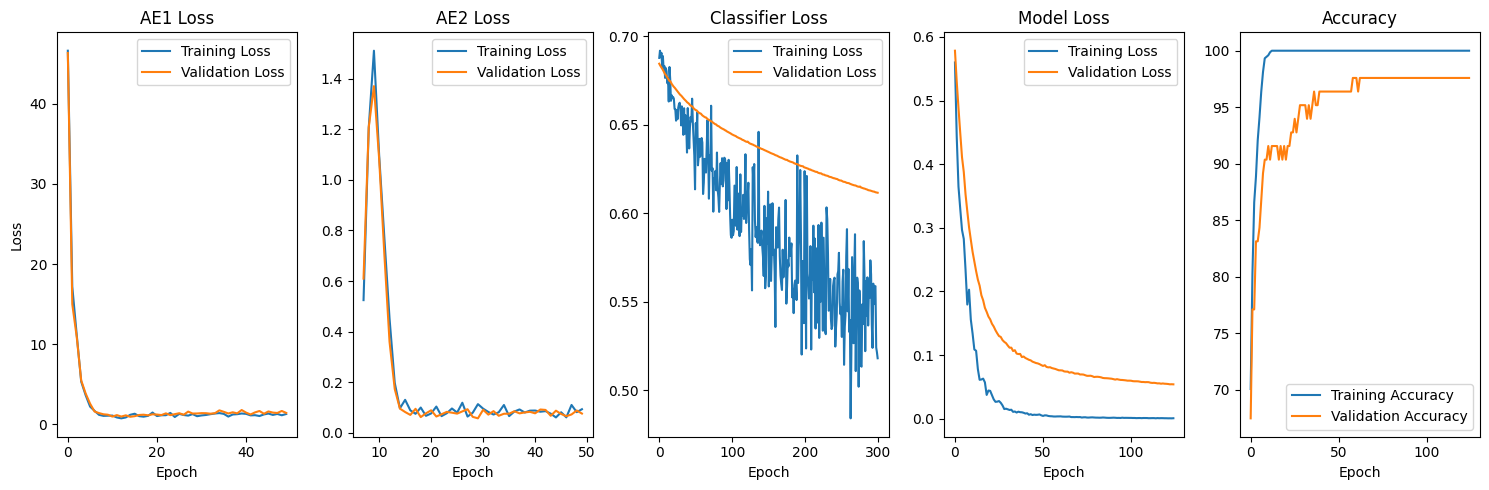

Testing Model
Accuracy: 95.65%
Specificity: 0.94
Precision: 0.94
F1_Score: 0.96
Confusion Matrix:
[[ 98   6]
 [  3 100]]
Split 2
Total:  1035
Train:  745
Test:  207
Validation:  83
AE 1: Epoch 0, loss 40.96767044067383, validation loss 40.96767044067383
AE 1: Epoch 1, loss 16.5954647064209, validation loss 16.5954647064209
AE 1: Epoch 2, loss 12.060564041137695, validation loss 12.060564041137695
AE 1: Epoch 3, loss 5.703546047210693, validation loss 5.703546047210693
AE 1: Epoch 4, loss 3.5618460178375244, validation loss 3.5618460178375244
AE 1: Epoch 5, loss 2.9109981060028076, validation loss 2.9109981060028076
AE 1: Epoch 6, loss 2.123298406600952, validation loss 2.123298406600952
AE 1: Epoch 7, loss 1.6892669200897217, validation loss 1.6892669200897217
AE 1: Epoch 8, loss 1.5010477304458618, validation loss 1.5010477304458618
AE 1: Epoch 9, loss 1.5562387704849243, validation loss 1.5562387704849243
AE 1: Epoch 10, loss 1.6186344623565674, validation loss 1.6186344623565674
AE 

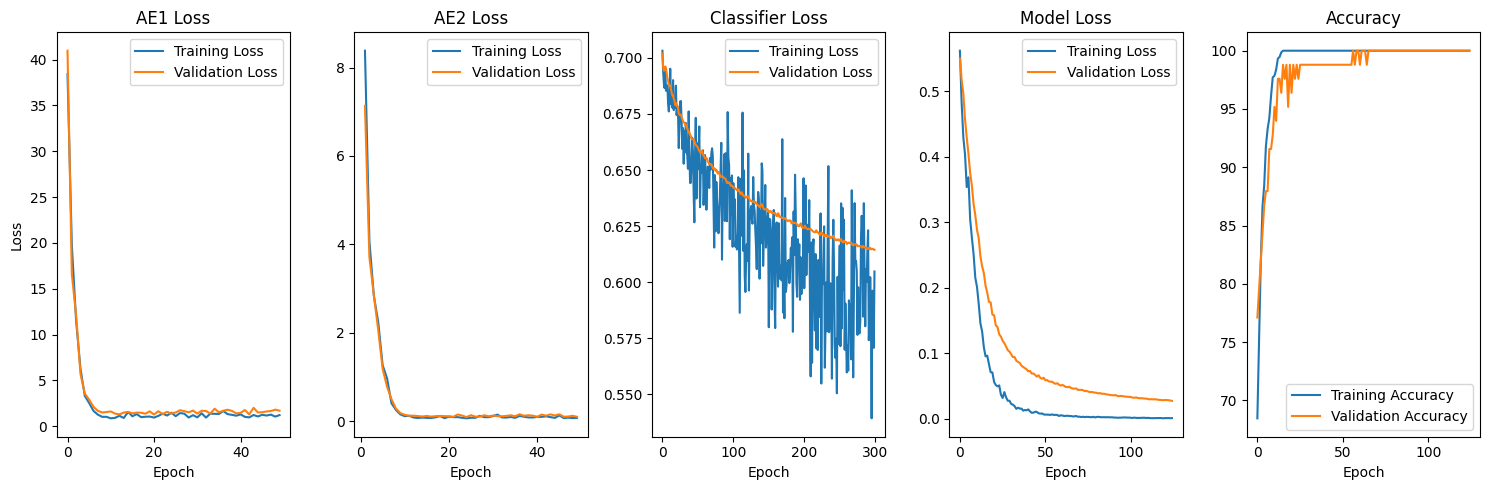

Testing Model
Accuracy: 99.03%
Specificity: 1.00
Precision: 1.00
F1_Score: 0.99
Confusion Matrix:
[[ 99   0]
 [  2 106]]
Split 3
Total:  1035
Train:  745
Test:  207
Validation:  83
AE 1: Epoch 0, loss inf, validation loss inf
AE 1: Epoch 1, loss 19.121217727661133, validation loss 19.121217727661133
AE 1: Epoch 2, loss 10.655399322509766, validation loss 10.655399322509766
AE 1: Epoch 3, loss 5.936864376068115, validation loss 5.936864376068115
AE 1: Epoch 4, loss 4.2928032875061035, validation loss 4.2928032875061035
AE 1: Epoch 5, loss 2.4246225357055664, validation loss 2.4246225357055664
AE 1: Epoch 6, loss 1.841435194015503, validation loss 1.841435194015503
AE 1: Epoch 7, loss 1.4352089166641235, validation loss 1.4352089166641235
AE 1: Epoch 8, loss 1.1173229217529297, validation loss 1.1173229217529297
AE 1: Epoch 9, loss 1.1126792430877686, validation loss 1.1126792430877686
AE 1: Epoch 10, loss 0.9931473135948181, validation loss 0.9931473135948181
AE 1: Epoch 11, loss 0.9417

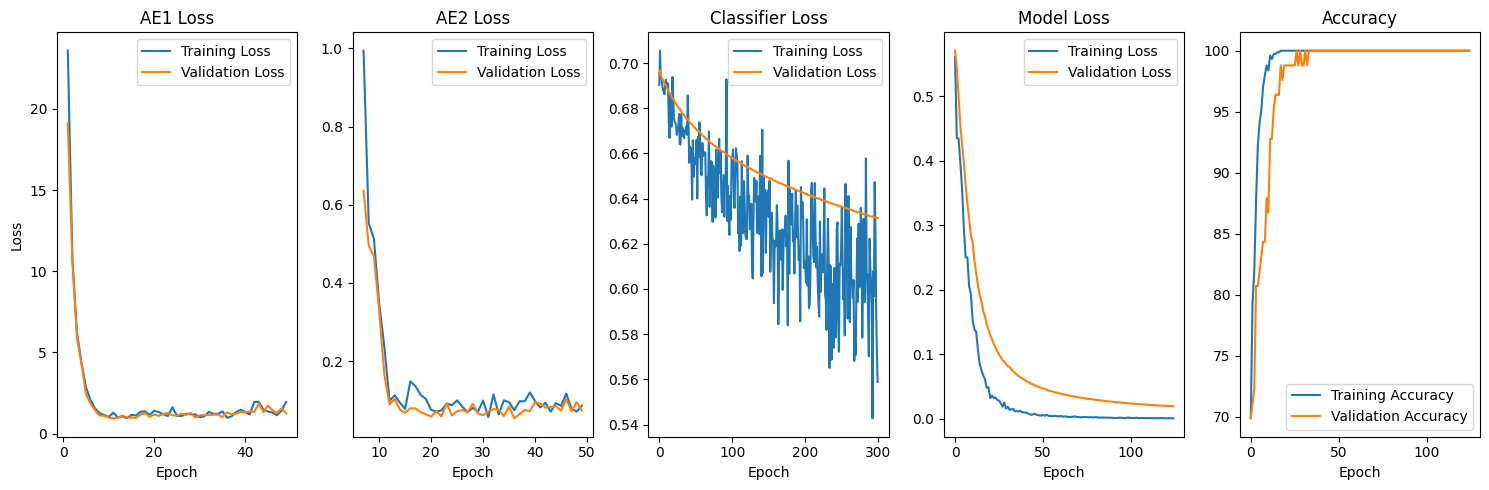

Testing Model
Accuracy: 97.58%
Specificity: 0.95
Precision: 0.95
F1_Score: 0.98
Confusion Matrix:
[[101   5]
 [  0 101]]
Split 4
Total:  1035
Train:  745
Test:  207
Validation:  83
AE 1: Epoch 0, loss inf, validation loss inf
AE 1: Epoch 1, loss 19.953128814697266, validation loss 19.953128814697266
AE 1: Epoch 2, loss 11.0220947265625, validation loss 11.0220947265625
AE 1: Epoch 3, loss 6.390186786651611, validation loss 6.390186786651611
AE 1: Epoch 4, loss 4.488195896148682, validation loss 4.488195896148682
AE 1: Epoch 5, loss 2.732302188873291, validation loss 2.732302188873291
AE 1: Epoch 6, loss 2.197061538696289, validation loss 2.197061538696289
AE 1: Epoch 7, loss 1.850517988204956, validation loss 1.850517988204956
AE 1: Epoch 8, loss 1.5188624858856201, validation loss 1.5188624858856201
AE 1: Epoch 9, loss 1.3028959035873413, validation loss 1.3028959035873413
AE 1: Epoch 10, loss 1.4300225973129272, validation loss 1.4300225973129272
AE 1: Epoch 11, loss 1.26832628250122

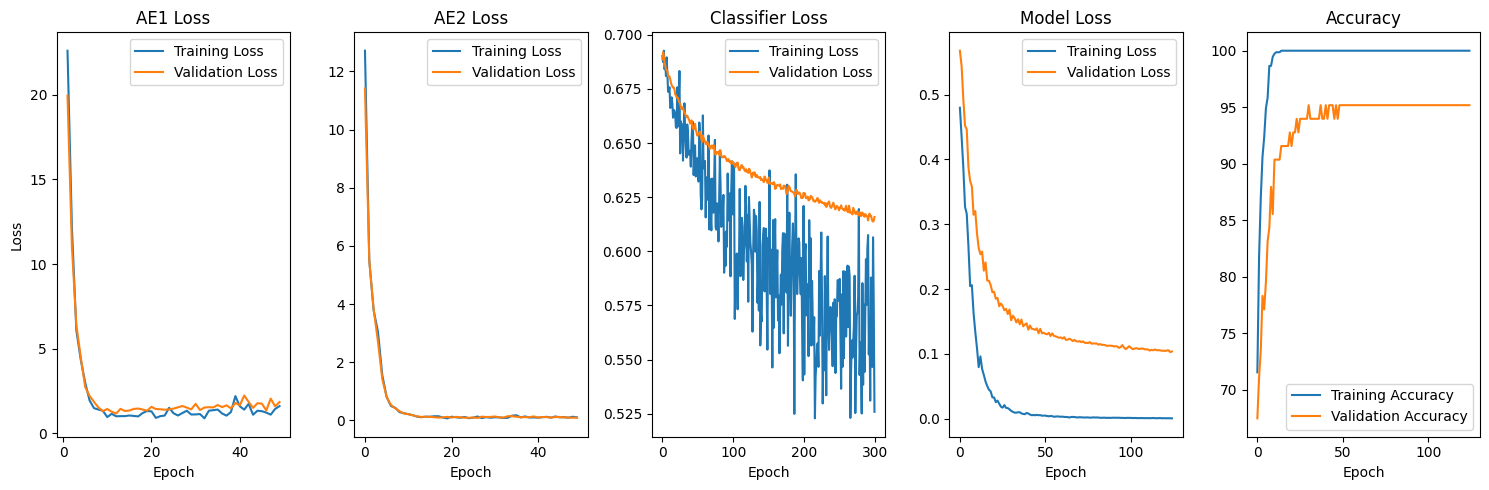

Testing Model
Accuracy: 98.07%
Specificity: 0.99
Precision: 0.99
F1_Score: 0.98
Confusion Matrix:
[[ 98   1]
 [  3 105]]
Split 5
Total:  1035
Train:  745
Test:  207
Validation:  83
AE 1: Epoch 0, loss 36.99472427368164, validation loss 36.99472427368164
AE 1: Epoch 1, loss 15.514485359191895, validation loss 15.514485359191895
AE 1: Epoch 2, loss 10.381827354431152, validation loss 10.381827354431152
AE 1: Epoch 3, loss 6.394818305969238, validation loss 6.394818305969238
AE 1: Epoch 4, loss 3.400890588760376, validation loss 3.400890588760376
AE 1: Epoch 5, loss 2.712878465652466, validation loss 2.712878465652466
AE 1: Epoch 6, loss 2.045898675918579, validation loss 2.045898675918579
AE 1: Epoch 7, loss 1.7130835056304932, validation loss 1.7130835056304932
AE 1: Epoch 8, loss 1.4414277076721191, validation loss 1.4414277076721191
AE 1: Epoch 9, loss 1.5015565156936646, validation loss 1.5015565156936646
AE 1: Epoch 10, loss 1.3645099401474, validation loss 1.3645099401474
AE 1: Epo

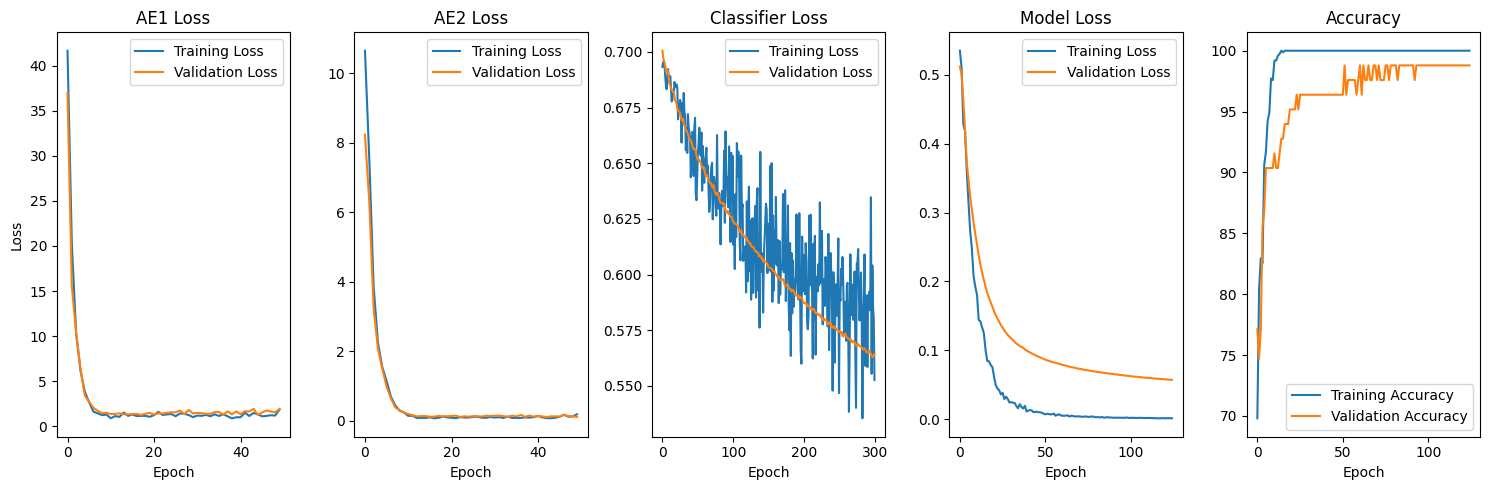

Testing Model
Accuracy: 98.07%
Specificity: 0.98
Precision: 0.98
F1_Score: 0.98
Confusion Matrix:
[[ 99   2]
 [  2 104]]
Completed splits
Accuracy: 97.68%
Specificity: 0.97
Precision: 0.97
F1_Score: 0.98
Confusion Matrix:
[[ 99.    2.8]
 [  2.  103.2]]


/usr/local/lib/python3.12/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/captum/attr/_core/deep_lift.py:810: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  attributions = super().attribute.__wrapped__(  # type: ignore
/usr/local/lib/python3.12/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


Integrated Gradients
[fetch_atlas_aal] Dataset found in /root/nilearn_data/aal_SPM12
[fetch_atlas_aal] Downloading data from https://www.gin.cnrs.fr/AAL_files/aal_for_SPM12.tar.gz ...
[fetch_atlas_aal] Error while fetching file aal_for_SPM12.tar.gz; dataset fetching aborted.


SSLError: HTTPSConnectionPool(host='www.gin.cnrs.fr', port=443): Max retries exceeded with url: /AAL_files/aal_for_SPM12.tar.gz (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)')))

In [ ]:
print("verbose: ", verbose)
print("train_model: ", train_model)
print("save_model: ", save_model)
print("interpretation_methods: ", interpretation_methods)
print("analyze_methods: ", analyze_methods)
# Set print options to display the whole array
# np.set_printoptions(threshold=np.inf)
print("Torch Cuda is Available =",use_cuda)
# seed = int(np.random.rand() * (2**32 - 1))
seed = 2109459083
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if use_cuda:
    torch.cuda.manual_seed_all(seed)
# ccs_dparsf = compare_pipelines('ccs', 'dparsf')
# ccs_cpac = compare_pipelines('cpac', 'ccs')
# cpac_dparsf = compare_pipelines('cpac', 'dparsf')
# overlap = ccs_dparsf.intersection(ccs_cpac)
# overlap = overlap.intersection(cpac_dparsf)
# # overlap = get_relaxed_overlap(ccs_dparsf, ccs_cpac)
# # overlap = get_relaxed_overlap(overlap, cpac_dparsf)
# print(f"Common ROIs between all pipelines: {overlap}")
# view_rois(list(overlap))
pipeline='cpac'
data, labels_from_abide = get_data_from_abide(pipeline)
RFE_step = 20
# feature_vecs, feature_vec_indices = get_feature_vecs(data)
# top_features, top_rois = get_top_features_from_SVM_RFE(feature_vecs, labels_from_abide, feature_vec_indices, 1000, RFE_step)
# np.savetxt(f'data/{pipeline}/sorted_top_features_{pipeline}_116_step{RFE_step}.csv', top_features, delimiter=",")
# np.savetxt(f'data/{pipeline}/sorted_top_rois_{pipeline}_116_step{RFE_step}.csv', top_rois, delimiter=",")

top_features = np.loadtxt(f'data/{pipeline}/sorted_top_features_{pipeline}_116_step{RFE_step}.csv', delimiter=',')
top_rois = np.loadtxt(f'data/{pipeline}/sorted_top_rois_{pipeline}_116_step{RFE_step}.csv', delimiter=',')
model, base_accuracy, train_dataloader, test_dataloader = train_and_eval_model(top_features, labels_from_abide, pipeline, verbose=verbose, train_model=train_model, save_model=save_model, rfe_step=RFE_step)


In [25]:
N_rois = 1000
N_rois_to_display = 50
rois_ig, weights_ig, indices_ig = find_top_rois_using_integrated_gradients(N_rois, model, test_dataloader, top_rois)
rois_shap, weights_shap, indices_shap = find_top_rois_using_SHAP(N_rois, model, test_dataloader, train_dataloader, top_rois)
rois_lime, weights_lime, indices_lime = find_top_rois_using_LIME(N_rois, model, test_dataloader, train_dataloader, top_rois)
rois_deeplift, weights_deeplift, indices_deeplift = find_top_rois_using_DeepLift(N_rois, model, test_dataloader, top_rois)
rois_deepliftshap, weights_deepliftshap, indices_deepliftshap = find_top_rois_using_DeepLiftShap(N_rois, model, test_dataloader, top_rois)
rois_gradientshap, weights_gradientshap, indices_gradientshap = find_top_rois_using_GradientShap(N_rois, model, test_dataloader, top_rois)
rois_guidedbackprop, weights_guidedbackprop, indices_guidedbackprop = find_top_rois_using_GuidedBackprop(N_rois, model, test_dataloader, top_rois)
interpretation_results = [
  (rois_ig, indices_ig, weights_ig, "Integrated Gradients"),
  (rois_shap, indices_shap, weights_shap, "SHAP"),
  (rois_lime, indices_lime, weights_lime, "LIME"),
  (rois_guidedbackprop, indices_guidedbackprop, weights_guidedbackprop, "GuidedBackprop"),
  (rois_deeplift, indices_deeplift, weights_deeplift, "DeepLift"),
  (rois_deepliftshap, indices_deepliftshap, weights_deepliftshap, "DeepLiftShap"),
  (rois_gradientshap, indices_gradientshap, weights_gradientshap, "GradientShap"),
]
if interpretation_methods:
  for i in interpretation_results:
    print("=" * 115,f'\n{i[3]}\n' + ('=' * 115))
    connections, rois = print_connections(i[0], i[2], i[3], pipeline, show_now=False, save=False, print_graph=False)
    print("\n Top Connections \n")
    print(connections.to_string(index=False))
    print("\n Top ROIs \n")
    print(rois.to_string(index=False))
  plt.show()
percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
if(analyze_methods):
  accuracies = roar(pipeline, top_features, labels_from_abide, interpretation_results, percentiles)
  with open(f'roar_accuracies_{pipeline}.json', 'w') as f:
    json.dump(accuracies, f)
else:
  with open(f'roar_accuracies_{pipeline}.json') as f:
    accuracies = json.load(f)
methods = list(accuracies.keys())
accuracies = list(accuracies.values())
percentiles = [0] + [i*100 for i in percentiles]
for method, accuracy in zip(methods,accuracies):
  accuracy = [base_accuracy] + accuracy
  method_accuracies = [i*100 for i in accuracy]
  plt.plot(percentiles, method_accuracies, label=method)
plt.legend()
plt.title('ROAR')
plt.xlabel('Percent of features removed')
plt.xticks(percentiles)
plt.ylabel('Accuracy')
plt.show()
print("Seed is",seed)

/usr/local/lib/python3.12/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/captum/attr/_core/deep_lift.py:810: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  attributions = super().attribute.__wrapped__(  # type: ignore
/usr/local/lib/python3.12/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


Integrated Gradients
[fetch_atlas_aal] Dataset found in /root/nilearn_data/aal_SPM12

 Top Connections 

             ROI 1      ROI 1 function             ROI 2      ROI 2 function Importance
       Calcarine_L   Visual processing        Amygdala_R  Emotion processing       10.0
          Cuneus_L   Visual perception       Calcarine_L   Visual processing        8.6
   Cerebelum_4_5_L Cerebellar function     Cerebelum_3_L Cerebellar function       7.05
   Occipital_Sup_L   Visual perception       Calcarine_L   Visual processing       7.01
   Occipital_Mid_L   Visual perception       Calcarine_L   Visual processing       6.77
          Cuneus_L   Visual perception        Amygdala_R  Emotion processing       6.44
        Thalamus_L       Sensory relay        Pallidum_R  Movement execution       6.16
          Vermis_8      Motor learning     Cerebelum_9_L Cerebellar function        6.0
Frontal_Inf_Oper_L   Speech production      Precentral_L       Motor control       5.95
 Cerebelum_Crus


 Top Connections 

          ROI 1        ROI 1 function             ROI 2      ROI 2 function Importance
  Cerebelum_6_L         Motor control          Cuneus_R   Visual perception       10.0
 Temporal_Sup_R   Auditory processing        Thalamus_R       Sensory relay       9.64
 Cerebelum_10_L Cerebellar processing        Amygdala_L  Emotion processing       9.56
    Calcarine_R     Visual processing    Cingulum_Ant_L     Decision making       9.33
     Pallidum_L    Movement execution        Amygdala_R  Emotion processing       9.33
Cerebelum_4_5_L   Cerebellar function          Cuneus_R   Visual perception       8.69
  Cerebelum_3_R   Cerebellar function    Temporal_Inf_L Auditory processing       8.35
     Pallidum_L    Movement execution Frontal_Med_Orb_L Behavioral impulses       8.33
Cerebelum_4_5_R   Cerebellar function ParaHippocampal_R     Memory encoding       8.15
  Cerebelum_8_R         Sensory motor    Cingulum_Mid_R  Emotional response       7.81

 Top ROIs 

          

KeyboardInterrupt: 

In [1]:
import argparse
import json
import random
import shap
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import colormaps, colorbar
import collections
import numpy as np
import pandas as pd
import os
import networkx as nx
from functools import reduce
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader, TensorDataset
from captum.attr import IntegratedGradients, DeepLift, DeepLiftShap, GradientShap, GuidedBackprop
from nilearn import datasets, plotting

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# ============================================================================
# Data Loading and Feature Extraction
# ============================================================================

def get_data_from_abide(pipeline):
  downloads = f'abide/downloads/Outputs/{pipeline}/filt_global/rois_aal/'
  pheno_file = 'data/Phenotypic_V1_0b_preprocessed1.csv'

  pheno_file = open(pheno_file, 'r')
  pheno_list = pheno_file.readlines()

  labels_dict = {}
  for i in pheno_list[1:]:
    file_name = i.split(',')[6]
    diagnosis = i.split(',')[7]
    labels_dict[file_name] = float(diagnosis)

  data = []
  labels = []

  for filename in sorted(os.listdir(downloads)):
    if filename.endswith('.1D'):
      filepath = os.path.join(downloads, filename)
      dataset = np.loadtxt(filepath)
      data.append(dataset)
      file_id = '_'.join(filename.split('_')[:-2])
      labels.append(labels_dict[file_id])

  labels = np.array(labels) - 1
  return data, labels

# ============================================================================
# Feature Extraction
# ============================================================================

def get_feature_vecs(data):
  roi_size = data[0].shape[1]
  feature_vecs = []
  feature_indices = []
  vectorized_fisher_transfrom = np.vectorize(fishers_z_transform)
  
  for i in range(len(data)):
    corr_coefs = np.corrcoef(data[i], rowvar=False)
    corr_coefs = np.nan_to_num(corr_coefs)
    f = []
    idx = []
    transformed_corr_coefs = vectorized_fisher_transfrom(corr_coefs)
    lower_triangular_indices = np.tril_indices(transformed_corr_coefs.shape[0], -1)

    for row_idx, col_idx in zip(*lower_triangular_indices):
      coefficient = transformed_corr_coefs[row_idx, col_idx]
      f.append(coefficient)
      idx.append([row_idx, col_idx])

    feature_vecs.append(f)
    feature_indices.append(idx)

  feature_vecs = np.array(feature_vecs)
  feature_indices = np.array(feature_indices)
  return feature_vecs, feature_indices
# ============================================================================
# Feature Selection (RFE)
# ============================================================================

def get_top_features_from_SVM_RFE(X, Y, indices, N, step):
  """Fit RFE on entire dataset and return selected features (WARNING: causes data leakage with CV)."""
  svm = SVC(kernel="linear")
  rfe = RFE(estimator=svm, n_features_to_select=N, step=step, verbose=1)
  rfe.fit(X, Y)
  top_features = rfe.transform(X)
  top_indices = np.where(rfe.support_)[0]
  top_ROIs = [indices[0][i] for i in top_indices]
  return top_features, np.array(top_ROIs) 

def fit_rfe_on_fold(X_train, y_train, X_val, X_test, N, step):
  """Fit RFE on training data only and apply to val/test data (prevents data leakage)."""
  svm = SVC(kernel="linear")
  rfe = RFE(estimator=svm, n_features_to_select=N, step=step, verbose=0)
  rfe.fit(X_train, y_train)
  X_train_selected = rfe.transform(X_train)
  X_val_selected = rfe.transform(X_val)
  X_test_selected = rfe.transform(X_test)
  return X_train_selected, X_val_selected, X_test_selected, rfe.support_
def fishers_z_transform(x):
  """Fisher's Z-transform for correlation coefficients."""
  if x == 1:
    return np.inf
  elif x == -1:
    return -np.inf
  else:
    return 0.5 * np.log((1 + x) / (1 - x))

def safe_divide(numerator, denominator):
  """Safely divide two numbers, avoiding division by zero."""
  return 0 if denominator == 0 else numerator / denominator

# ============================================================================
# Model Architecture
# ============================================================================

class Autoencoder(nn.Module):
  def __init__(self, input_size, encoded_output_size, rho=0.2, beta=2, criterion=nn.MSELoss()):
    """Sparse Autoencoder with KL divergence regularization."""
    super(Autoencoder, self).__init__()
    self.encoder = nn.Linear(input_size, encoded_output_size)
    self.decoder = nn.Linear(encoded_output_size, input_size)
    self.rho = rho
    self.beta = beta
    self.criterion = criterion
  
  def kl_divergence(self, rho, rho_hat):
    """Calculates KL divergence for sparsity regularization."""
    return rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
  
  def forward(self, x):
    encoded = torch.relu(self.encoder(x))
    rho_hat = torch.mean(encoded, dim=0)
    kl_loss = self.kl_divergence(self.rho, rho_hat).sum()
    decoded = self.decoder(encoded)
    mse_loss = self.criterion(decoded, x)
    loss = mse_loss + self.beta * kl_loss
    return encoded, decoded, loss

class SoftmaxClassifier(nn.Module):
  def __init__(self, input_size, num_classes):
    super(SoftmaxClassifier, self).__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    return self.linear(x)

class StackedAutoencoder(nn.Module):
  def __init__(self, AE1, AE2, classifier):
    super(StackedAutoencoder, self).__init__()
    self.ae1 = AE1
    self.ae2 = AE2
    self.classifier = classifier

  def forward(self, x):
    x = self.ae1.encoder(x)
    x = self.ae2.encoder(x)
    x = self.classifier(x)
    return x
  
class CustomDataset(Dataset):
  def __init__(self, data, labels):
    self.labels = labels
    self.data = data

  def __len__(self):
    return len(self.data.indices)
  
  def __getitem__(self, idx):
    data_idx = self.data.indices[idx]
    labels_idx = self.labels.indices[idx]
    return self.data.dataset[data_idx], self.labels.dataset[labels_idx]

# ============================================================================
# Data Encoding and Loading
# ============================================================================ 


def get_encoded_data(model, dataloader, dataloader_params, device):
  """Encodes data using a given model and returns a DataLoader with encoded features."""
  encoded_features_from_model = []
  labels_from_model = []

  for batch in dataloader:
    data, labels = batch
    data = data.float().to(device)
    with torch.no_grad():
      encoded_features, _, __ = model(data)
      encoded_features_from_model.append(encoded_features)
      labels_from_model.append(labels)

  encoded_dataset_tensor = torch.cat(encoded_features_from_model, dim=0)
  labels_tensor = torch.cat(labels_from_model, dim=0)
  encoded_dataset = TensorDataset(encoded_dataset_tensor, labels_tensor)
  encoded_dataset_loader = DataLoader(encoded_dataset, **dataloader_params)
  return encoded_dataset, encoded_dataset_loader


# ============================================================================
# Explainability Methods: ROI Attribution
# ============================================================================

# ============================================================================
# Explainability Methods: ROI Attribution
# ============================================================================

def find_top_rois_using_SHAP(N, model, test_dataloader, train_dataloader, rois):
  # Collect background data for SHAP explainer
  background_data = []
  for batch in train_dataloader:
    data, labels = batch
    data = data.float().to(device)
    background_data.append(data)
    if len(background_data) >= 100:
      break
  background_data = torch.cat(background_data)[:100]

  # Collect test instances to explain
  test_instances = []
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device)
    test_instances.append(data)
    if len(test_instances) >= 5:
      break
  test_instances = torch.cat(test_instances)[:5]

  background_data = background_data.to(device)
  test_instances = test_instances.to(device)

  # Compute SHAP values
  explainer = shap.DeepExplainer(model, background_data)
  shap_values = explainer.shap_values(test_instances)
  mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
  feature_importance = np.mean(mean_abs_shap_values, axis=1)
  top_indices = np.argsort(feature_importance)[-(N):][::-1]
  return rois[top_indices], feature_importance[top_indices], top_indices
  
def find_top_rois_using_integrated_gradients(N, model, test_dataloader, rois):
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device)
    labels = labels.long().to(device)
    break

  model.eval()
  data.requires_grad = True

  baseline = torch.zeros_like(data).to(device)
  integrated_gradients = IntegratedGradients(model)
  attributions_ig, delta = integrated_gradients.attribute(data, baselines=baseline, target=0, return_convergence_delta=True)
  attributions_mean = attributions_ig.mean(dim=0).cpu().detach().numpy()
  abs_attribution = np.abs(attributions_mean)
  top_indices = np.argsort(abs_attribution)[-(N):][::-1]
  return rois[top_indices], abs_attribution[top_indices], top_indices

def find_top_rois_using_DeepLift(N, model, test_dataloader, rois):
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device)
    labels = labels.long().to(device)
    break

  model.eval()
  data.requires_grad = True
  deep_lift = DeepLift(model)
  attributions_dl = deep_lift.attribute(data, target=0)
  attributions_mean = attributions_dl.mean(dim=0).cpu().detach().numpy()
  abs_attribution = np.abs(attributions_mean)
  top_indices = np.argsort(abs_attribution)[-(N):][::-1]
  return rois[top_indices], abs_attribution[top_indices], top_indices

def find_top_rois_using_DeepLiftShap(N, model, test_dataloader, rois):
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device)
    labels = labels.long().to(device)
    break

  model.eval()
  data.requires_grad = True
  baseline = torch.zeros_like(data).to(device)
  deep_lift_shap = DeepLiftShap(model)
  attributions_dls = deep_lift_shap.attribute(data, baselines=baseline, target=0)
  attributions_mean = attributions_dls.mean(dim=0).cpu().detach().numpy()
  abs_attribution = np.abs(attributions_mean)
  top_indices = np.argsort(abs_attribution)[-(N):][::-1]
  return rois[top_indices], abs_attribution[top_indices], top_indices

def find_top_rois_using_GradientShap(N, model, test_dataloader, rois):
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device)
    labels = labels.long().to(device)
    break

  model.eval()
  data.requires_grad = True
  baseline = torch.zeros_like(data).to(device)
  gradient_shap = GradientShap(model)
  attributions_gs = gradient_shap.attribute(data, baselines=baseline, target=0)
  attributions_mean = attributions_gs.mean(dim=0).cpu().detach().numpy()
  abs_attribution = np.abs(attributions_mean)
  top_indices = np.argsort(abs_attribution)[-(N):][::-1]
  return rois[top_indices], abs_attribution[top_indices], top_indices

def find_top_rois_using_GuidedBackprop(N, model, test_dataloader, rois):
  for batch in test_dataloader:
    data, labels = batch
    data = data.float().to(device)
    labels = labels.long().to(device)
    break

  model.eval()
  data.requires_grad = True
  guided_backprop = GuidedBackprop(model)
  attributions_gb = guided_backprop.attribute(data, target=0)
  attributions_mean = attributions_gb.mean(dim=0).cpu().detach().numpy()
  abs_attribution = np.abs(attributions_mean)
  top_indices = np.argsort(abs_attribution)[-(N):][::-1]
  return rois[top_indices], abs_attribution[top_indices], top_indices
# ============================================================================
# Network Visualization Utilities
# ============================================================================

def get_threshold_from_percentile(adjacency_matrix, percentile):
  all_weights = adjacency_matrix[np.nonzero(adjacency_matrix)]
  threshold = np.percentile(all_weights, percentile)
  return threshold

def expand_relative_coords(coordinates, percent):
  """Scale coordinates relative to their center."""
  center = np.mean(coordinates, axis=0)
  centered_coordinates = coordinates - center
  scaled_coordinates = centered_coordinates * percent
  return scaled_coordinates + center


def print_connections(rois, weights, method, pipeline, top_regions=50, top_regions_df=10, show_now=False, save=False, print_graph=True):
  """Visualize brain network connections and ROI importance."""
  atlas = datasets.fetch_atlas_aal(version='SPM12')
  labels = atlas.labels
  weights = np.array(weights)
  rois = rois.astype(int)[:top_regions]
  weights = ((weights - weights.min()) / (weights.max() - weights.min())) * 10
  weights = weights[:top_regions]
  num_connections = len(rois)
  cmap = colormaps['viridis']

  if print_graph:
    fig = plt.figure(figsize=(15, 8))
    ax_connection_connectome = fig.add_axes([0.05, 0.55, 0.8, 0.40])
    ax_connection_colorbar = fig.add_axes([0.85, 0.55, 0.05, 0.40])
    ax_roi_connectome = fig.add_axes([0.05, 0.05, 0.8, 0.40])
    ax_roi_colorbar = fig.add_axes([0.85, 0.05, 0.05, 0.40])
    fig.suptitle(f'Top {num_connections} connections and ROI Importance using {method} for {pipeline}', fontsize=16)

  G = nx.Graph()
  for label in labels:
    G.add_node(label)

  for i, roi_pair in enumerate(rois):
    roi1_index = int(roi_pair[0])
    roi2_index = int(roi_pair[1])
    roi1_name = labels[roi1_index]
    roi2_name = labels[roi2_index]
    weight = weights[i]
    G.add_edge(roi1_name, roi2_name, weight=weight)

  coordinates = expand_relative_coords(plotting.find_parcellation_cut_coords(atlas.maps), 1.08)
  adjacency_matrix = nx.adjacency_matrix(G).todense()
  edge_threshold = get_threshold_from_percentile(adjacency_matrix, 0)

  if print_graph:
    plotting.plot_connectome(adjacency_matrix, coordinates,
                            node_color='grey',
                            edge_vmin=0,
                            edge_vmax=weights.max(),
                            edge_cmap=cmap,
                            edge_threshold=edge_threshold,
                            axes=ax_connection_connectome)
    norm = Normalize(vmin=weights.min(), vmax=weights.max())
    cb = colorbar.ColorbarBase(ax_connection_colorbar, cmap=cmap, norm=norm, orientation='vertical')
    cb.set_label('Importance')

  # Count the occurrence of each ROI
  all_rois = [int(roi) for pair in rois for roi in pair]
  roi_counts = collections.Counter(all_rois)
  top_rois, top_counts = zip(*roi_counts.most_common())

  adjacency_matrix = np.zeros((len(coordinates), len(coordinates)))
  roi_importances = []

  for idx, label in enumerate(labels):
    if idx in top_rois:
      i = top_rois.index(idx)
      possible_weights = []
      for j in range(len(rois)):
        if float(idx) in rois[j]:
          possible_weights.append(weights[j])
      weight = max(possible_weights) if possible_weights else 1
      roi_importances.append((top_counts[i]+1)*weight)
    else:
      roi_importances.append(0.0001)

  roi_importances = np.array(roi_importances)
  normalized_sizes = 20 + (roi_importances - roi_importances.min()) / (roi_importances.max() - roi_importances.min()) * 180
  normalized_colors = cmap((roi_importances - roi_importances.min()) / (roi_importances.max() - roi_importances.min()))

  if print_graph:
    plotting.plot_connectome(adjacency_matrix, coordinates,
                          node_color=normalized_colors,
                          node_size=normalized_sizes,
                          display_mode='ortho',
                          colorbar=False,
                          axes=ax_roi_connectome)
    norm = Normalize(vmin=roi_importances.min(), vmax=roi_importances.max())
    cb = colorbar.ColorbarBase(ax_roi_colorbar, cmap=cmap, norm=norm, orientation='vertical')
    cb.set_label('Importance')

    if save:
      filename = f"plots/{pipeline}/{pipeline}_plot_{method}_{num_connections}_connections.png"
      plt.savefig(filename)

    if show_now:
      plt.show()

  with open('aal_roi_functions.json', 'r') as file:
    ROI_functions = json.load(file)

  labels = np.array(atlas.labels)
  top_connections = labels[rois[:top_regions_df]]
  connections_with_weights = np.array([(connection[0], ROI_functions[connection[0]], connection[1], ROI_functions[connection[1]], np.round(weight, 2)) 
                                        for connection, weight in zip(top_connections, weights)])
  top_connections_df = pd.DataFrame(connections_with_weights, columns=['ROI 1', 'ROI 1 function', 'ROI 2', 'ROI 2 function', 'Importance'])

  important_rois = np.argsort(roi_importances)[::-1]
  important_rois_weights = roi_importances[important_rois]
  important_rois_weights = 10 * ((important_rois_weights - important_rois_weights.min()) / (important_rois_weights.max() - important_rois_weights.min()))
  important_rois_with_weights = np.array([(labels[roi], ROI_functions[labels[roi]], np.round(weight, 2)) 
                                           for roi, weight in zip(important_rois, important_rois_weights)])
  top_rois_df = pd.DataFrame(important_rois_with_weights[:top_regions_df], columns=['ROI', 'Function', 'Importance'])

  return top_connections_df, top_rois_df

# ============================================================================
# Model Training and Evaluation
# ============================================================================

def train_and_eval_model(top_features, labels_from_abide, pipeline, verbose=False, train_model=True, save_model=False, rfe_step=1):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
  avg_TP, avg_FP, avg_FN, avg_TN = [], [], [], []

  fold = 0
  for train_idx, test_idx in skf.split(top_features, labels_from_abide):
    fold += 1

    if verbose:
      print(f'======================================\nSplit {fold}\n======================================')

    train_subidx, val_subidx = train_test_split(train_idx, test_size=0.1, random_state=seed)
    X_train = top_features[train_subidx]
    y_train = labels_from_abide[train_subidx]
    X_val = top_features[val_subidx]
    X_test = top_features[test_idx]
    
    X_train_selected, X_val_selected, X_test_selected, support_mask = fit_rfe_on_fold(
      X_train, y_train, X_val, X_test, N=1000, step=rfe_step
    )
    
    if verbose:
      print(f"RFE selected {np.sum(support_mask)} features out of {len(support_mask)}")
      print("Total: ", len(top_features))
      print("Train: ", len(X_train_selected))
      print("Test: ", len(X_test_selected))
      print("Validation: ", len(X_val_selected)) 

    # Create TensorDatasets instead of CustomDataset with Subsets
    train_set = TensorDataset(torch.from_numpy(X_train_selected).float(), torch.from_numpy(y_train).long())
    test_set = TensorDataset(torch.from_numpy(X_test_selected).float(), torch.from_numpy(labels_from_abide[test_idx]).long())
    val_set = TensorDataset(torch.from_numpy(X_val_selected).float(), torch.from_numpy(labels_from_abide[val_subidx]).long())

    params = {
      'batch_size': 128,
      'shuffle': True,
      'num_workers': 0
    }

    val_params = {
      'batch_size': 128,
      'shuffle': False,
      'num_workers': 0
    }

    test_params = {
      'batch_size': 128,
      'shuffle': False,
      'num_workers': 0
    }
    
    train_dataloader = DataLoader(train_set, **params)
    test_dataloader = DataLoader(test_set, **test_params)
    val_dataloader = DataLoader(val_set, **val_params)

    AE1 = Autoencoder(1000, 500).to(device)
    AE2 = Autoencoder(500, 100).to(device)
    classifier = SoftmaxClassifier(100, 2).to(device)
    model = StackedAutoencoder(AE1, AE2, classifier).to(device)

    if (train_model):
      AE1_epochs = 50
      optimizer_ae1 = optim.Adam( AE1.parameters(), lr=0.001, weight_decay=1e-4 )
      
      AE2_epochs = 50
      optimizer_ae2 = optim.Adam( AE2.parameters(), lr=0.001, weight_decay=1e-4 )

      classifier_epochs = 300
      optimizer_classifier = optim.Adam( classifier.parameters(), lr=0.001, weight_decay=1e-4 )

      optimizer = optim.Adam(model.parameters(), lr=0.0001)

      ae_criterion = nn.MSELoss()
      classifier_criterion = nn.CrossEntropyLoss()

      fine_tuning_epochs = 125

      loss_ae1 = []
      val_ae1 = []

      for epoch in range(AE1_epochs):
        for batch in train_dataloader:
          data, labels = batch
          data = data.float().to(device) 

          optimizer_ae1.zero_grad()

          encoded_features, decoded_featues, loss = AE1(data)

          loss.backward()
          optimizer_ae1.step()
        loss_ae1.append(loss.item())

        val_loss = 0.0
        with torch.no_grad():
          for batch in val_dataloader:
            data, labels = batch
            data = data.float().to(device)

            encoded_features, decoded_featues, loss = AE1(data)
            val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_ae1.append(val_loss)

        if verbose:
          print(f"AE 1: Epoch {epoch}, loss {loss.item()}, validation loss {val_loss}")
      
      if verbose:
        print("======================================\nTrained AE 1\n======================================")

      encoded_dataset, encoded_dataset_loader = get_encoded_data(AE1, train_dataloader, params, device)

      val_encoded_dataset, val_encoded_dataset_loader = get_encoded_data(AE1, val_dataloader, val_params, device)

      loss_ae2 = []
      val_ae2 = []

      for epoch in range(AE2_epochs):
        for batch in encoded_dataset_loader:
          data, labels = batch
          data = data.float().to(device) 

          optimizer_ae2.zero_grad()

          encoded_features, decoded_featues, loss = AE2(data)

          loss.backward()
          optimizer_ae2.step()
        loss_ae2.append(loss.item())

        val_loss = 0.0
        with torch.no_grad():
          for batch in val_encoded_dataset_loader:
            data, labels = batch
            data = data.float().to(device)

            encoded_features, decoded_featues, loss = AE2(data)
            val_loss += loss.item()

        val_loss /= len(val_encoded_dataset_loader)
        val_ae2.append(val_loss)

        if verbose:
          print(f"AE 2: Epoch {epoch}, loss {loss.item()}, validation loss {val_loss}")

      if verbose:
        print("======================================\nTrained AE 2\n======================================")

      encoded_dataset, encoded_dataset_loader = get_encoded_data(AE2, encoded_dataset_loader, params, device)

      val_encoded_dataset, val_encoded_dataset_loader = get_encoded_data(AE2, val_encoded_dataset_loader, val_params, device)

      loss_classifier = []
      val_classifier = []

      for epoch in range(classifier_epochs):
        for batch in encoded_dataset_loader:
          data, labels = batch
          data = data.float().to(device) 
          labels = labels.long().to(device) 

          optimizer_classifier.zero_grad()

          classifier_output = classifier(data)

          loss = classifier_criterion(classifier_output, labels)
          loss.backward()
          optimizer_classifier.step()

        loss_classifier.append(loss.item())

        val_loss = 0.0
        with torch.no_grad():
          for batch in val_encoded_dataset_loader:
            data, labels = batch
            data = data.float().to(device)
            labels = labels.long().to(device) 

            classifier_output = classifier(data)
            loss = classifier_criterion(classifier_output, labels)

            val_loss += loss.item()

        val_loss /= len(val_encoded_dataset_loader)  # Average validation loss
        val_classifier.append(val_loss)

        if verbose:
          print(f"Classifier: Epoch {epoch}, loss {loss.item()}, validation loss {val_loss}")

      if verbose:
        print("======================================\nTrained classifier\n======================================")

      loss_model = []
      accuracy_model = []
      val_model = []
      val_accuracy_model = []
      for epoch in range(fine_tuning_epochs):
        total = 0
        correct = 0
        for batch in train_dataloader:
          data, labels = batch
          data = data.float().to(device)
          labels = labels.long().to(device) 

          optimizer.zero_grad()
          outputs = model(data)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          loss = classifier_criterion(outputs, labels) 
          loss.backward()
          optimizer.step()
        loss_model.append(loss.item())
        accuracy_model.append(100 * correct / total)

        val_loss = 0.0
        val_total = 0
        val_correct = 0
        with torch.no_grad():
          for batch in val_dataloader:
            data, labels = batch
            data = data.float().to(device)
            labels = labels.long().to(device) 

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            loss = classifier_criterion(outputs, labels) 

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_loss += loss.item()

        val_accuracy_model.append(100 * val_correct / val_total)
        val_loss /= len(val_dataloader)
        val_model.append(val_loss)

        if verbose:
          print(f"Model: Epoch {epoch}, loss {loss.item()}, validation loss {val_loss}")
      
      if verbose:
        print("======================================\nFine tuned model\n======================================")

        dig, axs = plt.subplots(1, 5, figsize=(15,5))
        # Plot for AE1
        axs[0].plot(range(AE1_epochs), loss_ae1, label='Training Loss')
        axs[0].plot(range(AE1_epochs), val_ae1, label='Validation Loss')
        axs[0].set_title('AE1 Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot for AE2
        axs[1].plot(range(AE2_epochs), loss_ae2, label='Training Loss')
        axs[1].plot(range(AE2_epochs), val_ae2, label='Validation Loss')
        axs[1].set_title('AE2 Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].legend()

        # Plot for classifier
        axs[2].plot(range(classifier_epochs), loss_classifier, label='Training Loss')
        axs[2].plot(range(classifier_epochs), val_classifier, label='Validation Loss')
        axs[2].set_title('Classifier Loss')
        axs[2].set_xlabel('Epoch')
        axs[2].legend()

        # Plot for Model
        axs[3].plot(range(fine_tuning_epochs), loss_model, label='Training Loss')
        axs[3].plot(range(fine_tuning_epochs), val_model, label='Validation Loss')
        axs[3].set_title('Model Loss')
        axs[3].set_xlabel('Epoch')
        axs[3].legend()

        # Plot for Accuracy over fine tuning
        axs[4].plot(range(fine_tuning_epochs), accuracy_model, label='Training Accuracy')
        axs[4].plot(range(fine_tuning_epochs), val_accuracy_model, label='Validation Accuracy')
        axs[4].set_title('Accuracy')
        axs[4].set_xlabel('Epoch')
        axs[4].legend()

        plt.tight_layout()

        plt.show()

      if save_model:
        torch.save(model.state_dict(), f'models/model_{pipeline}_step{rfe_step}.pth')
    else:
      model.load_state_dict(torch.load(f'models/model_{pipeline}_step{rfe_step}.pth', map_location=torch.device(device)))

    if verbose:
      print("======================================\nTesting Model\n======================================")

    model.eval()

    true_labels = np.array([])
    predicted_labels = np.array([])

    for batch in test_dataloader:
      data, labels = batch
      data = data.float().to(device)
      labels = labels.long().to(device)

      outputs = model(data)

      _, predicted = torch.max(outputs.data, 1)

      true_labels = np.concatenate((true_labels,labels.cpu().numpy()),axis=0)
      predicted_labels = np.concatenate((predicted_labels,predicted.cpu().numpy()),axis=0)

    TP,FP,TN,FN = 0,0,0,0

    for true_label, predicted_label in zip(true_labels, predicted_labels):
      if true_label == predicted_label == 0:
          TP += 1  # True Positive
      elif true_label == predicted_label == 1:
          TN += 1  # True Negative
      elif true_label == 1 and predicted_label == 0:
          FP += 1  # False Positive
      elif true_label == 0 and predicted_label == 1:
          FN += 1  # False Negative
    
    avg_TP.append(TP)
    avg_FP.append(FP)
    avg_FN.append(FN)
    avg_TN.append(TN)

    accuracy = safe_divide(TP + TN, TP + TN + FP + FN)
    sensitivity = safe_divide(TP, TP + FN)
    specificity = safe_divide(TN, TN + FP)
    precision = safe_divide(TP, TP + FP)
    
    f1 = safe_divide((2 * precision * sensitivity), (precision + sensitivity))
    cm = np.array([[TP,FP],[FN,TN]])

    if verbose:
      print(f'Accuracy: {(accuracy * 100):.2f}%')
      print(f'Specificity: {specificity:.2f}')
      print(f'Precision: {precision:.2f}')
      print(f'F1_Score: {f1:.2f}')
      print(f'Confusion Matrix:\n{cm}')
      # sns.heatmap(cm, annot=True)

      # group_names = ['True Pos','False Pos','False Neg','True Neg']
      # group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
      # group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
      # labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
      # labels = np.asarray(labels).reshape(2,2)
      # sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
  
  if verbose:
    print("======================================\nCompleted splits\n======================================")
  TP = sum(avg_TP)/len(avg_TP)
  FP = sum(avg_FP)/len(avg_FP)
  FN = sum(avg_FN)/len(avg_FN)
  TN = sum(avg_TN)/len(avg_TN)

  accuracy = safe_divide(TP + TN, TP + TN + FP + FN)
  sensitivity = safe_divide(TP, TP + FN)
  specificity = safe_divide(TN, TN + FP)
  precision = safe_divide(TP, TP + FP)
  
  f1 = safe_divide((2 * precision * sensitivity), (precision + sensitivity))
  cm = np.array([[TP,FP],[FN,TN]])

  print(f'Accuracy: {(accuracy * 100):.2f}%')
  print(f'Specificity: {specificity:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'F1_Score: {f1:.2f}')
  print(f'Confusion Matrix:\n{cm}')

  return model, accuracy, train_dataloader, test_dataloader


# ============================================================================
# Analysis and Visualization Utilities
# ============================================================================

def overlap_coefficient(set_a, set_b):
  """Calculate overlap coefficient between two sets."""
  set_a = set(set_a)
  set_b = set(set_b)
  intersection = len(set_a.intersection(set_b))
  min_size = min(len(set_a), len(set_b))
  intersection = len(set_a.intersection(set_b))
  min_size = min(len(set_a), len(set_b))
  return intersection / min_size if min_size > 0 else 0


def calculate_similarity_metrics(connections_a, connections_b):
  """Calculate similarity metrics between two connection sets."""
  overlap_coef = overlap_coefficient(connections_a, connections_b)
  connections_a = set(connections_a)
  connections_b = set(connections_b)
  all_connections = list(set(connections_a) | set(connections_b))
  vector_a = np.array([1 if conn in connections_a else 0 for conn in all_connections])
  vector_b = np.array([1 if conn in connections_b else 0 for conn in all_connections])
  jaccard = jaccard_score(vector_a, vector_b)
  cosine_sim = cosine_similarity([vector_a], [vector_b])[0][0]
  return jaccard, cosine_sim, overlap_coef


def calculate_spatial_overlap(connections1, connections2):
  """Calculate spatial overlap between two connection sets."""
  roi_set1 = set(connections1)
  roi_set2 = set(connections2)
  overlap = roi_set1.intersection(roi_set2)
  overlap_fraction = len(overlap) / len(roi_set1.union(roi_set2))
  return overlap_fraction


def get_top_rois(pipeline, labels_from_abide, RFE_step=20, N_rois=1000):
  """Extract top ROIs for a given pipeline using Integrated Gradients."""
  top_features = np.loadtxt(f'data/{pipeline}/sorted_top_features_{pipeline}_116_step{RFE_step}.csv', delimiter=',')
  top_rois = np.loadtxt(f'data/{pipeline}/sorted_top_rois_{pipeline}_116_step{RFE_step}.csv', delimiter=',')
  model, _, _, test_dataloader = train_and_eval_model(top_features, labels_from_abide, pipeline, verbose=False, train_model=False, save_model=False, rfe_step=RFE_step)
  rois_ig, weights_ig, indices_ig = find_top_rois_using_integrated_gradients(N_rois, model, test_dataloader, top_rois)
  connections, rois = print_connections(rois_ig, weights_ig, "Integrated Gradients", pipeline, top_regions=100, top_regions_df=10, show_now=False, save=False, print_graph=False)
  return rois


# ============================================================================
# Visualization
# ============================================================================

def view_rois(rois):
  """Visualize selected ROIs using nilearn."""
  atlas = datasets.fetch_atlas_aal(version='SPM12')
  labels = atlas.labels
  label_indices = {label: index for index, label in enumerate(labels)}
  filtered_indices = [label_indices[roi] for roi in rois if roi in label_indices]
  filtered_labels = [labels[index] for index in filtered_indices]
  coordinates = plotting.find_parcellation_cut_coords(atlas.maps)
  filtered_coordinates = [coordinates[index] for index in filtered_indices]
  
  plotting_params = {
    'marker_color': [],
    'marker_size': [],
    'marker_labels': [],
    'coordinates': coordinates
  }

  for idx, coord in enumerate(coordinates):
    if any(np.allclose(coord, fc) for fc in filtered_coordinates):
      plotting_params['marker_color'].append('yellow')
      plotting_params['marker_size'].append(25)
      plotting_params['marker_labels'].append(labels[idx])
    else:
      plotting_params['marker_color'].append('darkblue')
      plotting_params['marker_size'].append(10)
      plotting_params['marker_labels'].append('')

  all_markers = plotting.view_markers(plotting_params['coordinates'], marker_labels=plotting_params['marker_labels'], 
                                      marker_color=plotting_params['marker_color'], marker_size=plotting_params['marker_size'])
  all_markers.open_in_browser()

# ============================================================================
# Main Execution
# ============================================================================

verbose = True
train_model = True
save_model = False
interpretation_methods = True
analyze_methods = True
print("verbose:", verbose)
print("train_model:", train_model)
print("save_model:", save_model)
print("interpretation_methods:", interpretation_methods)
print("analyze_methods:", analyze_methods)
print("Torch CUDA is available:", use_cuda)
# Set random seeds for reproducibility
seed = 2109459083
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if use_cuda:
  torch.cuda.manual_seed_all(seed)
# Main pipeline
pipeline = 'cpac'
data, labels_from_abide = get_data_from_abide(pipeline)
RFE_step = 20
feature_vecs, feature_vec_indices = get_feature_vecs(data)
top_rois = feature_vec_indices[0]
print(f"Total features generated: {len(feature_vecs[0])}")
print(f"Shape of feature vectors: {feature_vecs.shape}")
model, base_accuracy, train_dataloader, test_dataloader = train_and_eval_model(
  feature_vecs, labels_from_abide, pipeline,
  verbose=verbose, train_model=train_model, save_model=save_model, rfe_step=RFE_step
)

verbose: True
train_model: True
save_model: False
interpretation_methods: True
analyze_methods: True
Torch CUDA is available: True


FileNotFoundError: [Errno 2] No such file or directory: 'data/Phenotypic_V1_0b_preprocessed1.csv'